# ANALYSIS

In [962]:
# import libraries
from elasticsearch import Elasticsearch, helpers
from elasticsearch.dsl import Search
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from pprint import pprint
import json
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object as pdhash
from datetime import datetime, timedelta
import pytz # Thư viện để xử lý múi giờ

pd.set_option('display.max_columns', None)

### Read log from elasticsearch (Docker ELK)

In [963]:
# Establish connection to Elasticsearch
conn = Elasticsearch(
    # ['https://192.168.145.101:9200'], 
    ['http://localhost:9200'],
    # ca_certs=False, 
    # verify_certs=False,
    # basic_auth=('jupyter', 'jupyter@seconi.com'),
    # basic_auth=('nialliceh@gmail.com', 'nialliceh3108'),
    basic_auth=('analyzer_internal', 'analyzer'),
)

print(conn.info())
# print(conn.indices.get_data_stream(name="logs-zeek*"))

# --- Search across all filebeat Zeek indices ---
zlog = Search(using=conn, index="filebeat-*")

# --- Define Zeek datasets ---
datasets = {
    "conn": "zeek.connection",
    "http": "zeek.http",
    "dns": "zeek.dns",
    "ssl": "zeek.ssl"
}

# 1. Định nghĩa múi giờ của bạn (Việt Nam, UTC+7)
local_tz = pytz.timezone("Asia/Ho_Chi_Minh")

start_time_local = local_tz.localize(datetime(2025, 10, 6, 23, 0, 0))
end_time_local = local_tz.localize(datetime(2025, 10, 7, 8, 0, 0))

print(f"Querying data from {start_time_local.isoformat()} to {end_time_local.isoformat()}")


dfs = {}  # store DataFrames for each type

for name, dataset in datasets.items():
    print(f"Fetching {dataset} logs...")

    query = (
        zlog.query("term", **{"event.dataset": dataset})
            .filter("range", **{
                "@timestamp": {
                    "gte": start_time_local.isoformat(),
                    "lt": end_time_local.isoformat()
                }
            })
    )

    # Collect results
    rows = []
    for hit in query.scan():
        doc = hit.to_dict()
        rows.append(doc)   # keep full parsed document (all ECS + Zeek fields)

    # Convert to DataFrame
    if rows:
        df = pd.json_normalize(rows, sep='.')
        dfs[name] = df
        print(f"✅ {dataset}: {len(df)} rows, {len(df.columns)} columns")
    else:
        print(f"⚠️ {dataset}: no data found")

for name, df in dfs.items():
    df['@timestamp'] = pd.to_datetime(df['@timestamp']).dt.tz_convert('Asia/Bangkok')
    df['ts'] = df['@timestamp'].astype('int64') / 1e9


# convert to zeek log format

conn_df = dfs['conn'][['ts', 'source.ip', 'destination.ip', 'destination.port', 'event.duration', 'source.bytes']]
# rename columns for clarity
conn_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'id.resp_p', 'duration', 'orig_ip_bytes']
conn_df.head()


ssl_df = dfs['ssl'][['ts', 'source.ip', 'destination.ip', 'zeek.ssl.sni_matches_cert', 'zeek.ssl.server.name', 'tls.client.ja3']]
ssl_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'sni_matches_cert', 'server_name', 'ja3']
ssl_df.head()

http_df = dfs['http'][['ts', 'source.ip', 'destination.ip', 'url.domain', 'http.response.body.bytes', 'user_agent.original']]
http_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'host', 'response_body_len', 'user_agent']
http_df.head()

dns_df = dfs['dns'][['ts', 'source.ip', 'destination.ip', 'zeek.dns.query', 'zeek.dns.qtype_name', 'zeek.dns.rcode_name']]
dns_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'query', 'qtype_name', 'rcode_name']
dns_df.head()

{'name': 'elasticsearch', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'Pu_iQyxxRKaCyWAkyvdUmA', 'version': {'number': '9.1.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'ca1a70216fbdefbef3c65b1dff04903ea5964ef5', 'build_date': '2025-08-11T15:04:41.449624592Z', 'build_snapshot': False, 'lucene_version': '10.2.2', 'minimum_wire_compatibility_version': '8.19.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'}
Querying data from 2025-10-06T23:00:00+07:00 to 2025-10-07T08:00:00+07:00
Fetching zeek.connection logs...
✅ zeek.connection: 5512 rows, 60 columns
Fetching zeek.http logs...
✅ zeek.http: 69 rows, 67 columns
Fetching zeek.dns logs...
✅ zeek.dns: 1556 rows, 65 columns
Fetching zeek.ssl logs...
✅ zeek.ssl: 3492 rows, 65 columns


,ts,id.orig_h,id.resp_h,query,qtype_name,rcode_name
0,1.759798e+09,192.168.28.129,192.168.28.2,array601.prod.do.dsp.mp.microsoft.com,A,NOERROR
1,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
2,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
3,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
4,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN


### Read log from csv

In [ ]:
# # read csv file to dataframe
# conn_df = pd.read_csv('zeek_conn_12h.csv')
# http_df = pd.read_csv('zeek_http_12h.csv')
# dns_df = pd.read_csv('zeek_dns_12h.csv')
# ssl_df = pd.read_csv('zeek_ssl_12h.csv')

### Read log from zeek

In [ ]:
# # Read zeek log to DataFrame
def read_zeek_log(file_path):
    # Lấy tên cột từ dòng "#fields"
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#fields"):
                columns = line.strip().split("\t")[1:]  # bỏ "#fields"
                break

    # Đọc dữ liệu, bỏ các dòng metadata
    df = pd.read_csv(
        file_path,
        sep="\t",
        comment="#",      # bỏ các dòng bắt đầu bằng "#"
        names=columns,    # dùng tên cột lấy từ #fields
        na_values=["-"],  # thay "-" bằng NaN
    )
    return df

path = "./../traffic/log/taidoor/"

conn_df = read_zeek_log(path + "conn.log")
http_df = read_zeek_log(path + "http.log")
dns_df = read_zeek_log(path + "dns.log")
ssl_df = read_zeek_log(path + "ssl.log")
# x509_df = read_zeek_log(path + "x509.log")

## conn.log

In [964]:
# 1. remove logs where dstIP in whitelist
WHITELIST_IP = ['8.8.8.8', '1.1.1.1']
conn_df = conn_df.loc[~conn_df['id.resp_h'].isin(WHITELIST_IP)]
conn_df

,ts,id.orig_h,id.resp_h,id.resp_p,duration,orig_ip_bytes
0,1.759781e+09,192.168.28.129,4.213.25.241,443.0,2.000388e+13,9546
1,1.759799e+09,192.168.28.129,27.67.51.50,443.0,9.590442e+11,17571
2,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.062198e+09,1322
3,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.067019e+09,1322
4,1.759798e+09,192.168.28.129,192.168.28.2,53.0,7.430792e+06,58
...,...,...,...,...,...,...
5507,1.759794e+09,192.168.28.1,239.255.255.250,1900.0,3.002357e+09,804
5508,1.759794e+09,192.168.28.129,20.189.173.6,443.0,9.450050e+09,44413
5509,1.759794e+09,192.168.28.129,13.89.179.13,443.0,1.105389e+10,9354
5510,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.085080e+09,1322


In [965]:
# 2. check common port
common_ports = {80, 443, 53, 22, 25, 21, 5353}

conn_df['rare_port'] = conn_df['id.resp_p'].apply(lambda x: 0 if x in common_ports else 1)
conn_df

,ts,id.orig_h,id.resp_h,id.resp_p,duration,orig_ip_bytes,rare_port
0,1.759781e+09,192.168.28.129,4.213.25.241,443.0,2.000388e+13,9546,0
1,1.759799e+09,192.168.28.129,27.67.51.50,443.0,9.590442e+11,17571,0
2,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.062198e+09,1322,1
3,1.759798e+09,192.168.28.129,192.168.20.100,8081.0,1.067019e+09,1322,1
4,1.759798e+09,192.168.28.129,192.168.28.2,53.0,7.430792e+06,58,0
...,...,...,...,...,...,...,...
5507,1.759794e+09,192.168.28.1,239.255.255.250,1900.0,3.002357e+09,804,1
5508,1.759794e+09,192.168.28.129,20.189.173.6,443.0,9.450050e+09,44413,0
5509,1.759794e+09,192.168.28.129,13.89.179.13,443.0,1.105389e+10,9354,0
5510,1.759794e+09,192.168.28.129,192.168.20.100,8081.0,1.085080e+09,1322,1


In [ ]:
# group by srcIP, dstIP

rows = []

conn_df = conn_df.sort_values(by=['ts'])
conn_grouped = conn_df.groupby(['id.orig_h', 'id.resp_h', 'id.resp_p'])
for name, group in conn_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'dstPort': name[2],
        'timeList': group["ts"].tolist(),
        'dataList': group['orig_ip_bytes'].tolist(),
        'durList': [v for v in group['duration'].tolist() if pd.notna(v)],
        'rare_port': max(group['rare_port'].tolist()),
    })
grcon_df = pd.DataFrame(rows)

,srcIP,dstIP,dstPort,timeList,dataList,durList,rare_port
0,0.0.0.0,255.255.255.255,67.0,[1759780792.2489998],[350],[],1
1,192.168.20.81,192.168.28.129,49235.0,[1759786174.1139998],[40],[],1
2,192.168.20.81,192.168.28.129,49236.0,[1759786174.1139998],[40],[],1
3,192.168.20.81,192.168.28.129,49435.0,[1759787382.4339998],[40],[],1
4,192.168.20.81,192.168.28.129,49436.0,[1759787382.4339998],[40],[],1
...,...,...,...,...,...,...,...
216,fe80::6d9f:7800:3b30:3f76,ff02::1:2,547.0,[1759780792.2910001],[1144],[64110574961.0],1
217,fe80::6d9f:7800:3b30:3f76,ff02::1:3,5355.0,"[1759778211.225, 1759779111.257, 1759780011.32...","[81, 81, 81, 162, 162, 81, 81, 81, 81, 81, 81,...","[421327114.0, 428045988.0]",1
218,fe80::6d9f:7800:3b30:3f76,ff02::c,1900.0,[1759780795.775],[572],[5921873093.0],1
219,fe80::6d9f:7800:3b30:3f76,ff02::c,3702.0,"[1759780516.8049998, 1759780793.671, 175978079...","[1640, 4560, 2688]","[74282885.0, 686932087.0, 5481935024.0]",1


In [992]:
# 3. check IoC list for dstIP
with open('ioc_ip.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

grcon_df.loc[:, 'ip_ioc'] = np.where(grcon_df['dstIP'].isin(ioc_list), 1, 0)

grcon_df

,srcIP,dstIP,dstPort,timeList,dataList,durList,rare_port,ip_ioc,time_bskew,time_mad,time_acf,data_bskew,data_mad,data_acf,dur_bskew,dur_mad,dur_acf
0,0.0.0.0,255.255.255.255,67.0,[1759780792.2489998],[350],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,192.168.20.81,192.168.28.129,49235.0,[1759786174.1139998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,192.168.20.81,192.168.28.129,49236.0,[1759786174.1139998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,192.168.20.81,192.168.28.129,49435.0,[1759787382.4339998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,192.168.20.81,192.168.28.129,49436.0,[1759787382.4339998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,fe80::6d9f:7800:3b30:3f76,ff02::1:2,547.0,[1759780792.2910001],[1144],[64110574961.0],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
217,fe80::6d9f:7800:3b30:3f76,ff02::1:3,5355.0,"[1759778211.225, 1759779111.257, 1759780011.32...","[81, 81, 81, 162, 162, 81, 81, 81, 81, 81, 81,...","[421327114.0, 428045988.0]",1,0,0.000120,0.999896,0.209558,1.0,1.0,1.000000,0.000000,0.000000,0.000000
218,fe80::6d9f:7800:3b30:3f76,ff02::c,1900.0,[1759780795.775],[572],[5921873093.0],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
219,fe80::6d9f:7800:3b30:3f76,ff02::c,3702.0,"[1759780516.8049998, 1759780793.671, 175978079...","[1640, 4560, 2688]","[74282885.0, 686932087.0, 5481935024.0]",1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [968]:
# Calc Bowkey skewness and Median Absolute Deviation

# --- Lọc outlier bằng IQR ---
def remove_outliers_iqr(data, factor=1.5):
    if len(data) < 5:
        return np.array(data)
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return data[(data >= lower) & (data <= upper)]

# --- Tính độ lệch Bowley (mức độ đối xứng của phân phối) ---
def calc_bowley_skewness(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    q1, q2, q3 = np.percentile(data, [25, 50, 75])
    if (q3 - q1) == 0:
        return 1.0
    bowley_skewness = (q3 + q1 - 2 * q2) / (q3 - q1)
    score = 1 - abs(bowley_skewness)  # 1 là đối xứng hoàn hảo
    return score

# --- Tính MAD (độ phân tán quanh trung vị) ---
def calc_median_absolute_deviation(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    cv_mad = mad / median if median != 0 else 0
    score = 1.0 / (1.0 + cv_mad)  # 1 là ổn định tuyệt đối
    return score

# --- Hàm tổng hợp theo cửa sổ (window-based) ---
def rolling_score(data, func, window_size=20, agg="median"):
    if len(data) < window_size:
        return func(np.array(data))
    
    scores = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = np.array(data[i:i+window_size])
        score = func(window)
        scores.append(score)
    
    if len(scores) == 0:
        return 0.0

    if agg == "median":
        return np.median(scores)
    elif agg == "mean":
        return np.mean(scores)
    elif agg == "max":
        return np.max(scores)
    else:
        raise ValueError("agg must be 'median', 'mean', or 'max'")

# Calc autocorrelation v2 using statsmodels
def calc_autocorrelation_v2(data: list) -> float:
    if len(data) < 5:
        return 0.0
    
    data = remove_outliers_iqr(np.array(data))

    if len(data) < 2 or np.var(data) == 0:
        return 1 # beacon deu

    nlags = len(data) // 2

    try:
        autocorr_values = acf(data, nlags=nlags, fft=True)
        autocorr_values = np.nan_to_num(autocorr_values, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        return 0.0

    if len(autocorr_values) < 2:
        return 0.0

    score = np.max(np.clip(autocorr_values[1:], 0, 1))  # chỉ quan tâm lag > 0
    return score

In [969]:
# save row with timeList length < 5 for the next analysis
# save_df = grcon_df[grcon_df['timeList'].apply(len) < 5]
# save_df.to_csv('conn_next_batch.csv', index=False)

In [970]:
# Calc features

def ts_to_interval(ts):
    return np.diff(ts)

grcon_df['time_bskew'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grcon_df['time_mad'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grcon_df['time_acf'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

grcon_df['data_bskew'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['data_mad'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['data_acf'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df['dur_bskew'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['dur_mad'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['dur_acf'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df

,srcIP,dstIP,dstPort,timeList,dataList,durList,rare_port,ip_ioc,time_bskew,time_mad,time_acf,data_bskew,data_mad,data_acf,dur_bskew,dur_mad,dur_acf
0,0.0.0.0,255.255.255.255,67.0,[1759780792.2489998],[350],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,192.168.20.81,192.168.28.129,49235.0,[1759786174.1139998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,192.168.20.81,192.168.28.129,49236.0,[1759786174.1139998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,192.168.20.81,192.168.28.129,49435.0,[1759787382.4339998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,192.168.20.81,192.168.28.129,49436.0,[1759787382.4339998],[40],[],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,fe80::6d9f:7800:3b30:3f76,ff02::1:2,547.0,[1759780792.2910001],[1144],[64110574961.0],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
217,fe80::6d9f:7800:3b30:3f76,ff02::1:3,5355.0,"[1759778211.225, 1759779111.257, 1759780011.32...","[81, 81, 81, 162, 162, 81, 81, 81, 81, 81, 81,...","[421327114.0, 428045988.0]",1,0,0.000120,0.999896,0.209558,1.0,1.0,1.000000,0.000000,0.000000,0.000000
218,fe80::6d9f:7800:3b30:3f76,ff02::c,1900.0,[1759780795.775],[572],[5921873093.0],1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
219,fe80::6d9f:7800:3b30:3f76,ff02::c,3702.0,"[1759780516.8049998, 1759780793.671, 175978079...","[1640, 4560, 2688]","[74282885.0, 686932087.0, 5481935024.0]",1,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
# calc conn final score
final_con = grcon_df.groupby(['srcIP', 'dstIP']).agg({
    'time_bskew': 'max',
    'time_mad': 'max',
    'time_acf': 'max',
    'data_bskew': 'max',
    'data_mad': 'max',
    'dur_bskew': 'max',
    'dur_mad': 'max',
    'dur_acf': 'max',
    'rare_port': 'max',
    'ip_ioc': 'max',
}).reset_index()
# final_con.set_index(['srcIP', 'dstIP'], inplace=True)
final_con['time_score'] = final_con[['time_bskew', 'time_mad']].mean(axis=1)
final_con['time_score'] = final_con[['time_score', 'time_acf']].max(axis=1)

final_con['data_score'] = final_con[['data_bskew', 'data_mad']].mean(axis=1)

final_con['dur_score'] = final_con[['dur_bskew', 'dur_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_score', 'dur_acf']].max(axis=1)

final_con['conn_score'] = final_con[['time_score', 'data_score']].mean(axis=1)
# if dur_score > 0.6, increase final_score by 10% as a bonus, but not exceed 1.0
final_con['conn_score'] = np.where(final_con['dur_score'] > 0.6, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['rare_port'] == 1, final_con['conn_score'] * 1.1, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['ip_ioc'] == 1, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = final_con['conn_score'].clip(upper=1.0)
# only keep important columns
final_con = final_con[['srcIP', 'dstIP', 'conn_score', 'rare_port', 'ip_ioc']]
final_con

,srcIP,dstIP,conn_score,rare_port,ip_ioc
0,0.0.0.0,255.255.255.255,0.000000,1,0
1,192.168.20.81,192.168.28.129,0.000000,1,0
2,192.168.28.1,224.0.0.251,0.805759,0,0
3,192.168.28.1,239.255.255.250,0.990039,1,0
4,192.168.28.129,103.43.90.115,0.000000,0,0
...,...,...,...,...,...
182,fe80::250:56ff:fec0:9,ff02::fb,0.750000,0,0
183,fe80::6d9f:7800:3b30:3f76,ff02::1:2,0.000000,1,0
184,fe80::6d9f:7800:3b30:3f76,ff02::1:3,0.825004,1,0
185,fe80::6d9f:7800:3b30:3f76,ff02::c,0.000000,1,0


## ssl.log

In [974]:
# 3. check JA3
with open('ioc_ja3.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)

ssl_df

/tmp/ipykernel_1251063/3527806339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)


,ts,id.orig_h,id.resp_h,sni_matches_cert,server_name,ja3,ja3_ioc
0,1.759798e+09,192.168.28.129,192.168.20.100,NaN,NaN,19e29534fd49dd27d09234e639c4057e,0
1,1.759798e+09,192.168.28.129,192.168.20.100,NaN,NaN,19e29534fd49dd27d09234e639c4057e,0
2,1.759798e+09,192.168.28.129,192.168.20.100,NaN,NaN,19e29534fd49dd27d09234e639c4057e,0
3,1.759798e+09,192.168.28.129,192.168.20.100,NaN,NaN,19e29534fd49dd27d09234e639c4057e,0
4,1.759798e+09,192.168.28.129,72.145.35.96,True,array601.prod.do.dsp.mp.microsoft.com,28a2c9bd18a11de089ef85a160da29e4,0
...,...,...,...,...,...,...,...
3487,1.759794e+09,192.168.28.129,20.189.173.6,True,v20.events.data.microsoft.com,28a2c9bd18a11de089ef85a160da29e4,0
3488,1.759794e+09,192.168.28.129,192.168.20.100,NaN,NaN,19e29534fd49dd27d09234e639c4057e,0
3489,1.759794e+09,192.168.28.129,192.168.20.100,NaN,NaN,19e29534fd49dd27d09234e639c4057e,0
3490,1.759794e+09,192.168.28.129,142.250.197.110,NaN,www.youtube.com,6e7d85b2d04f95eb6ff358826f448e17,0


In [975]:
# group by srcIP, dstIP
rows = []
ssl_df = ssl_df.sort_values(by=['ts'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'id.resp_h'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'sni_matches_cert': max(group['sni_matches_cert'].tolist()),
    })
grssl_df = pd.DataFrame(rows)
grssl_df.set_index(['srcIP', 'dstIP'], inplace=True)

for index, row in ssl_df.iterrows():
    if pd.isna(row['sni_matches_cert']):
        ssl_df.at[index, 'sni_matches_cert'] = grssl_df.loc[(row['id.orig_h'], row['id.resp_h']), 'sni_matches_cert']

In [976]:
# 4. check SNI
# ssl_df.loc[:, 'sni_not_matched_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

def extract_domain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[-2:]) if len(parts) >= 2 else fqdn

SAFE_DOMAINS = [
    'google.com','gstatic.com','youtube.com','ggpht.com',
    'microsoft.com','windowsupdate.com','office.com','msftconnecttest.com',
    'apple.com','icloud.com','mzstatic.com',
    'facebook.com','fbcdn.net','instagram.com','whatsapp.net',
    'cloudflare.com','cdn.cloudflare.net',
    'dns.google','quad9.net','a.root-servers.net','b.root-servers.net','c.root-servers.net',
    'd.root-servers.net','e.root-servers.net','f.root-servers.net','g.root-servers.net',
    'h.root-servers.net','i.root-servers.net','j.root-servers.net','k.root-servers.net',
    'l.root-servers.net','m.root-servers.net'
] # service that not likely to be used for domain fronting

ssl_df = ssl_df[~(
    (ssl_df['sni_matches_cert'] == True) &
    (ssl_df['server_name'].apply(lambda x: extract_domain(x)).isin(SAFE_DOMAINS))
)]

In [977]:
# group by srcIP, server_name, sni_not_matched_cert
rows = []
ssl_df['sni_not_matches_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

ssl_df = ssl_df.sort_values(by=['ts'])
ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'server_name', 'sni_not_matches_cert'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'server_name': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'ja3_ioc': max(group['ja3_ioc'].tolist()),
        'sni_not_matched_cert': name[2],
    })
grssl_df = pd.DataFrame(rows)

/tmp/ipykernel_1251063/862565668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssl_df['sni_not_matches_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)


In [978]:
# Calc features
grssl_df['time_bskew'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grssl_df['time_mad'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grssl_df['time_acf'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grssl_df

,srcIP,server_name,dstIPList,timeList,ja3_ioc,sni_not_matched_cert,time_bskew,time_mad,time_acf
0,192.168.28.129,192.168.20.100,[192.168.20.100],"[1759781650.29, 1759781651.33, 1759781658.973,...",0,0,0.829849,0.905001,0.238134
1,192.168.28.129,9469210.fls.doubleclick.net,[142.250.71.230],"[1759781888.9190001, 1759781889.176]",0,0,0.000000,0.000000,0.000000
2,192.168.28.129,accounts.google.com,[74.125.130.84],[1759781888.591],0,0,0.000000,0.000000,0.000000
3,192.168.28.129,accounts.shopee.co.id,[202.181.90.190],"[1759781911.021, 1759781911.022]",0,0,0.000000,0.000000,0.000000
4,192.168.28.129,ad-log.dable.io,[43.200.77.115],[1759781259.675],0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
95,192.168.28.129,www.googleadservices.com,[142.250.71.162],[1759778703.3660002],0,0,0.000000,0.000000,0.000000
96,192.168.28.129,www.googletagmanager.com,[142.250.76.8],"[1759781884.451, 1759781885.1820002, 175978188...",0,0,0.000000,0.000000,0.000000
97,192.168.28.129,www.gstatic.com,[142.250.198.35],"[1759781836.345, 1759781853.492]",0,0,0.000000,0.000000,0.000000
98,192.168.28.129,www.youtube.com,"[142.250.71.142, 142.250.76.14, 142.250.76.238...","[1759777783.3379998, 1759777823.05, 1759777863...",0,0,0.731157,0.999563,0.304592


In [979]:
# merge grssl_df to final_ssl
# get max of mean(time_bskew, time_mad) and time_acf
grssl_df['ssl_score'] = grssl_df[['time_bskew', 'time_mad']].mean(axis=1)
grssl_df['ssl_score'] = grssl_df[['ssl_score', 'time_acf']].max(axis=1)
# if ja3_ioc == 1, increase ssl_score by 20% as a bonus, but not exceed 1.0
grssl_df['ssl_score'] = np.where(grssl_df['ja3_ioc'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = np.where(grssl_df['sni_not_matched_cert'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = grssl_df['ssl_score'].clip(upper=1.0)
grssl_df

final_ssl = grssl_df.explode('dstIPList', ignore_index=True)
final_ssl = final_ssl.rename(columns={'dstIPList': 'dstIP'})
# final_ssl.set_index(['srcIP', 'dstIP'], inplace=True)
final_ssl = final_ssl[['srcIP', 'dstIP', 'ssl_score', 'ja3_ioc', 'sni_not_matched_cert']]
final_ssl

,srcIP,dstIP,ssl_score,ja3_ioc,sni_not_matched_cert
0,192.168.28.129,192.168.20.100,0.867425,0,0
1,192.168.28.129,142.250.71.230,0.000000,0,0
2,192.168.28.129,74.125.130.84,0.000000,0,0
3,192.168.28.129,202.181.90.190,0.000000,0,0
4,192.168.28.129,43.200.77.115,0.000000,0,0
...,...,...,...,...,...
148,192.168.28.129,142.250.197.142,0.865360,0,0
149,192.168.28.129,142.250.71.238,0.865360,0,0
150,192.168.28.129,142.250.198.142,0.865360,0,0
151,192.168.28.129,142.250.71.206,0.865360,0,0


## http.log

In [980]:
http_df

,ts,id.orig_h,id.resp_h,host,response_body_len,user_agent
0,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,0,Microsoft BITS/7.8
1,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,1120,Microsoft BITS/7.8
2,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,1090,Microsoft BITS/7.8
3,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,3881,Microsoft BITS/7.8
4,1.759799e+09,192.168.28.129,146.75.46.172,msedge.b.tlu.dl.delivery.mp.microsoft.com,9309,Microsoft BITS/7.8
...,...,...,...,...,...,...
64,1.759789e+09,192.168.28.129,146.75.46.172,ctldl.windowsupdate.com,0,Microsoft-CryptoAPI/10.0
65,1.759790e+09,192.168.28.129,146.75.46.172,ctldl.windowsupdate.com,0,Microsoft-CryptoAPI/10.0
66,1.759792e+09,192.168.28.129,146.75.46.172,ctldl.windowsupdate.com,0,Microsoft-CryptoAPI/10.0
67,1.759793e+09,192.168.28.129,146.75.46.172,ctldl.windowsupdate.com,0,Microsoft-CryptoAPI/10.0


In [981]:
# check User-Agent
http_df['null_user_agent'] = http_df['user_agent'].apply(lambda x: 1 if pd.isna(x) else 0)

/tmp/ipykernel_1251063/3694351915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  http_df['null_user_agent'] = http_df['user_agent'].apply(lambda x: 1 if pd.isna(x) else 0)


In [982]:
# group by srcIP, Host
rows = []
http_df = http_df.sort_values(by=['ts'])
http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
http_grouped = http_df.groupby(['id.orig_h', 'host'])
for name, group in http_grouped:
    rows.append({
        'srcIP': name[0],
        'host': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'dataList': group['response_body_len'].tolist(),
        'null_user_agent': 1 if pd.isna(group['user_agent']).any() else 0
    })
grhttp_df = pd.DataFrame(rows)
grhttp_df

,srcIP,host,dstIPList,timeList,dataList,null_user_agent
0,192.168.28.129,192.168.20.100:8000,[192.168.20.100],"[1759781274.7900002, 1759781274.908, 175978129...","[1932, 335, 242, 15879168, 15879168, 301, 1603...",0
1,192.168.28.129,ctldl.windowsupdate.com,"[146.75.46.172, 125.235.36.170]","[1759777863.034, 1759778543.524, 1759780854.93...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,192.168.28.129,msedge.b.tlu.dl.delivery.mp.microsoft.com,[146.75.46.172],"[1759778489.9350002, 1759778490.039, 175977849...","[0, 1120, 1347, 4500, 10368, 6024, 0, 1120, 17...",0
3,192.168.28.129,ocsp.digicert.com,"[23.50.21.119, 23.66.33.52]","[1759780793.388, 1759780793.39, 1759780793.457...","[471, 314, 313, 314, 471, 311, 471, 471, 313]",0


Improve:
- nslookup `host` matches IP?
- IP has no domain registered -> mark sus
- group by extracted domain of `host`?

In [983]:
# Calc features

grhttp_df['time_bskew'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grhttp_df['time_mad'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grhttp_df['time_acf'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

grhttp_df['data_bskew'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grhttp_df['data_mad'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grhttp_df['data_acf'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))
grhttp_df

,srcIP,host,dstIPList,timeList,dataList,null_user_agent,time_bskew,time_mad,time_acf,data_bskew,data_mad,data_acf
0,192.168.28.129,192.168.20.100:8000,[192.168.20.100],"[1759781274.7900002, 1759781274.908, 175978129...","[1932, 335, 242, 15879168, 15879168, 301, 1603...",0,0.000660,0.521177,0.534028,0.000203,0.533407,0.014708
1,192.168.28.129,ctldl.windowsupdate.com,"[146.75.46.172, 125.235.36.170]","[1759777863.034, 1759778543.524, 1759780854.93...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.389769,0.624130,0.796278,1.000000,1.000000,1.000000
2,192.168.28.129,msedge.b.tlu.dl.delivery.mp.microsoft.com,[146.75.46.172],"[1759778489.9350002, 1759778490.039, 175977849...","[0, 1120, 1347, 4500, 10368, 6024, 0, 1120, 17...",0,0.121599,0.811976,0.179031,0.686825,0.501048,0.342087
3,192.168.28.129,ocsp.digicert.com,"[23.50.21.119, 23.66.33.52]","[1759780793.388, 1759780793.39, 1759780793.457...","[471, 314, 313, 314, 471, 311, 471, 471, 313]",0,0.004646,0.500304,0.000000,0.012658,0.990536,0.000000


In [985]:
# merge grhttp_df to final_http

grhttp_df['time_score'] = grhttp_df[['time_bskew', 'time_mad']].mean(axis=1)
grhttp_df['time_score'] = grhttp_df[['time_score', 'time_acf']].max(axis=1)

grhttp_df['data_score'] = grhttp_df[['data_bskew', 'data_mad']].mean(axis=1)

grhttp_df['http_score'] = (grhttp_df['time_score'] + grhttp_df['data_score']) / 2
# if null_user_agent == 1, increase http_score by 20% as a bonus, but not exceed 1.0
grhttp_df['http_score'] = np.where(grhttp_df['null_user_agent'] == 1, grhttp_df['http_score'] * 1.2, grhttp_df['http_score'])
grhttp_df['http_score'] = grhttp_df['http_score'].clip(upper=1.0)

final_http = grhttp_df.explode('dstIPList', ignore_index=True)
final_http = final_http.rename(columns={'dstIPList': 'dstIP'})
# final_http.set_index(['srcIP', 'dstIP'], inplace=True)
final_http = final_http[['srcIP', 'dstIP', 'http_score', 'null_user_agent']]

final_http

,srcIP,dstIP,http_score,null_user_agent
0,192.168.28.129,192.168.20.100,0.400417,0
1,192.168.28.129,146.75.46.172,0.898139,0
2,192.168.28.129,125.235.36.170,0.898139,0
3,192.168.28.129,146.75.46.172,0.530362,0
4,192.168.28.129,23.50.21.119,0.377036,0
5,192.168.28.129,23.66.33.52,0.377036,0


## dns.log

In [987]:
# remove logs with nan query
dns_df = dns_df[~pd.isna(dns_df['query'])]
dns_df

,ts,id.orig_h,id.resp_h,query,qtype_name,rcode_name
0,1.759798e+09,192.168.28.129,192.168.28.2,array601.prod.do.dsp.mp.microsoft.com,A,NOERROR
1,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
2,1.759798e+09,192.168.28.129,192.168.28.2,array621.prod.do.dsp.mp.microsoft.com,A,NOERROR
3,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
4,1.759798e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
...,...,...,...,...,...,...
1551,1.759794e+09,192.168.28.129,192.168.28.2,v10.events.data.microsoft.com,A,NOERROR
1552,1.759794e+09,192.168.28.129,192.168.28.2,v20.events.data.microsoft.com,A,NOERROR
1553,1.759794e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN
1554,1.759794e+09,192.168.28.129,192.168.28.2,wpad.localdomain,A,NaN


In [ ]:
# group by srcIP, domain
dns_df.loc[:, 'domain'] = dns_df['query'].apply(lambda x: extract_domain(x))

def extract_subdomain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[:-2]) if len(parts) > 2 else ''

rows = []
dns_df = dns_df.sort_values(by=['ts'])
dns_grouped = dns_df.groupby(['id.orig_h', 'domain'])
for name, group in dns_grouped:
    rows.append({
        'srcIP': name[0],
        'domain': name[1],
        'timeList': group["ts"].tolist(),
        'subdmList': group['query'].apply(lambda x: extract_subdomain(x)).tolist(),
        '%TXT/CNAME': sum(group['qtype_name'].isin(['TXT', 'CNAME'])),
        '%NXDOMAIN': sum(group['rcode_name'] == 'NXDOMAIN'),
    })

grdns_df = pd.DataFrame(rows)
grdns_df['%TXT/CNAME'] = grdns_df['%TXT/CNAME'] / grdns_df['timeList'].apply(len)
grdns_df['%NXDOMAIN'] = grdns_df['%NXDOMAIN'] / grdns_df['timeList'].apply(len)
grdns_df['%unique_subdm'] = grdns_df['subdmList'].apply(lambda x: len(set(x))) / grdns_df['timeList'].apply(len)
grdns_df['dm_avg_len'] = grdns_df['subdmList'].apply(lambda x: np.mean([len(s) for s in x]) if len(x) > 0 else 0) + grdns_df['domain'].apply(lambda x: len(x))
grdns_df

,srcIP,domain,timeList,subdmList,%TXT/CNAME,%NXDOMAIN,%unique_subdm,dm_avg_len
0,192.168.28.1,_tcp.local,"[1759777884.912, 1759777884.912, 1759777885.91...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.045455,20.045455
1,192.168.28.129,0c1300b3-e393-4567-b8c5-2734ee8002d8.local,"[1759781911.824, 1759781912.8270001, 175978194...","[, , ]",0.0,0.0,0.333333,42.000000
2,192.168.28.129,4bee46c9-a139-4977-992f-8d53d6ef52a0.local,"[1759781913.839, 1759781914.832]","[, ]",0.0,0.0,0.500000,42.000000
3,192.168.28.129,8f8cd0a9-bbb0-4247-9887-25738388e6d7.local,"[1759781887.1529999, 1759781888.1590002, 17597...","[, , ]",0.0,0.0,0.333333,42.000000
4,192.168.28.129,94fe41c1-fa4d-41c6-8517-adc515b4fc4d.local,"[1759781915.864, 1759781916.8339999]","[, ]",0.0,0.0,0.500000,42.000000
...,...,...,...,...,...,...,...,...
69,fe80::6d9f:7800:3b30:3f76,_tcp.local,"[1759780795.028, 1759780795.029, 1759780796.04...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.083333,21.000000
70,fe80::6d9f:7800:3b30:3f76,b5b84801-1bcc-4ecd-95b2-ab79247d5c52.local,"[1759781889.156, 1759781890.164]","[, ]",0.0,0.0,0.500000,42.000000
71,fe80::6d9f:7800:3b30:3f76,b7a3f608-1d2f-4d22-8844-e94c1a3f7162.local,"[1759781891.168, 1759781892.1699998]","[, ]",0.0,0.0,0.500000,42.000000
72,fe80::6d9f:7800:3b30:3f76,desktop-78v07kr,"[1759778211.225, 1759779111.257, 1759780011.32...","[, , , , , , , , , , , , , , , , , , , , , , ,...",0.0,0.0,0.027778,15.000000


In [872]:
# Calc features
grdns_df['time_bskew'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grdns_df['time_mad'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grdns_df['time_acf'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grdns_df

,srcIP,domain,timeList,subdmList,%TXT/CNAME,%NXDOMAIN,%unique_subdm,dm_avg_len,time_bskew,time_mad,time_acf
0,192.168.28.1,_tcp.local,"[1759777884.912, 1759777884.912, 1759777885.91...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.045455,20.045455,0.001499,0.500000,0.480974
1,192.168.28.129,0c1300b3-e393-4567-b8c5-2734ee8002d8.local,"[1759781911.824, 1759781912.8270001, 175978194...","[, , ]",0.0,0.0,0.333333,42.000000,0.000000,0.000000,0.000000
2,192.168.28.129,4bee46c9-a139-4977-992f-8d53d6ef52a0.local,"[1759781913.839, 1759781914.832]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
3,192.168.28.129,8f8cd0a9-bbb0-4247-9887-25738388e6d7.local,"[1759781887.1529999, 1759781888.1590002, 17597...","[, , ]",0.0,0.0,0.333333,42.000000,0.000000,0.000000,0.000000
4,192.168.28.129,94fe41c1-fa4d-41c6-8517-adc515b4fc4d.local,"[1759781915.864, 1759781916.8339999]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
69,fe80::6d9f:7800:3b30:3f76,_tcp.local,"[1759780795.028, 1759780795.029, 1759780796.04...","[_googlecast, _googlecast, _googlecast, _googl...",0.0,0.0,0.083333,21.000000,0.001328,0.500000,0.564330
70,fe80::6d9f:7800:3b30:3f76,b5b84801-1bcc-4ecd-95b2-ab79247d5c52.local,"[1759781889.156, 1759781890.164]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
71,fe80::6d9f:7800:3b30:3f76,b7a3f608-1d2f-4d22-8844-e94c1a3f7162.local,"[1759781891.168, 1759781892.1699998]","[, ]",0.0,0.0,0.500000,42.000000,0.000000,0.000000,0.000000
72,fe80::6d9f:7800:3b30:3f76,desktop-78v07kr,"[1759778211.225, 1759779111.257, 1759780011.32...","[, , , , , , , , , , , , , , , , , , , , , , ,...",0.0,0.0,0.027778,15.000000,0.003371,0.998271,0.140004


In [ ]:
# merge grdns_df to final_dns
grdns_df['high_TXT/CNAME_ratio'] = np.where(grdns_df['%TXT/CNAME'] > 0.5, 1, 0)
grdns_df['high_NXDOMAIN_ratio'] = np.where(grdns_df['%NXDOMAIN'] > 0.5, 1, 0)
grdns_df['high_unique_subdm_ratio'] = np.where(grdns_df['%unique_subdm'] > 0.5, 1, 0)
grdns_df['long_dm_avg_len'] = np.where(grdns_df['dm_avg_len'] > 40, 1, 0)

grdns_df['dns_score'] = grdns_df[['time_bskew', 'time_mad']].mean(axis=1)
grdns_df['dns_score'] = grdns_df[['dns_score', 'time_acf']].max(axis=1)

grdns_df['dns_score'] = np.where(grdns_df['high_TXT/CNAME_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_NXDOMAIN_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_unique_subdm_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['long_dm_avg_len'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = grdns_df['dns_score'].clip(upper=1.0)

final_dns = grdns_df.explode('domain', ignore_index=True)
final_dns = final_dns.rename(columns={'domain': 'dstIP'})
# final_dns.set_index(['srcIP', 'dstIP'], inplace=True)
final_dns = final_dns[['srcIP', 'dstIP', 'dns_score', 'high_TXT/CNAME_ratio', 'high_NXDOMAIN_ratio', 'high_unique_subdm_ratio', 'long_dm_avg_len']]
final_dns

,srcIP,dstIP,dns_score,high_TXT/CNAME_ratio,high_NXDOMAIN_ratio,high_unique_subdm_ratio,long_dm_avg_len
0,192.168.28.1,_tcp.local,0.327491,0,0,0,0
1,192.168.28.129,0c1300b3-e393-4567-b8c5-2734ee8002d8.local,0.000000,0,0,0,1
2,192.168.28.129,4bee46c9-a139-4977-992f-8d53d6ef52a0.local,0.000000,0,0,0,1
3,192.168.28.129,8f8cd0a9-bbb0-4247-9887-25738388e6d7.local,0.000000,0,0,0,1
4,192.168.28.129,94fe41c1-fa4d-41c6-8517-adc515b4fc4d.local,0.000000,0,0,0,1
...,...,...,...,...,...,...,...
69,fe80::6d9f:7800:3b30:3f76,_tcp.local,0.355219,0,0,0,0
70,fe80::6d9f:7800:3b30:3f76,b5b84801-1bcc-4ecd-95b2-ab79247d5c52.local,0.000000,0,0,0,1
71,fe80::6d9f:7800:3b30:3f76,b7a3f608-1d2f-4d22-8844-e94c1a3f7162.local,0.000000,0,0,0,1
72,fe80::6d9f:7800:3b30:3f76,desktop-78v07kr,0.380549,0,0,0,0


In [ ]:
# Merge all scores to final_df

def merge_with_reason(base_df, new_df, score_col, reason_map):
    """
    Hợp nhất DataFrame phát hiện beacon theo IP pair.
    - Giữ lại duy nhất một score_col.
    - Gộp reason nếu nhiều điều kiện match.
    """
    # Nếu base_df đã có score_col thì xóa (tránh sinh _x/_y)
    if score_col in base_df.columns:
        base_df = base_df.drop(columns=[score_col])

    # Merge theo IP pair
    merged = base_df.merge(
        new_df[['srcIP', 'dstIP', score_col] + list(reason_map.keys())],
        on=['srcIP', 'dstIP'],
        how='outer'
    )

    # Bổ sung cột reason nếu thiếu
    merged['reason'] = merged['reason'].fillna('')

    # Thêm mô tả vào reason nếu flag = 1
    for col, msg in reason_map.items():
        merged.loc[merged[col] == 1, 'reason'] = (
            merged['reason'].astype(str).str.strip() +
            np.where(merged['reason'].astype(bool), '; ', '') +
            msg
        )

    # Xóa cột flag sau khi xử lý
    merged = merged.drop(columns=reason_map.keys())

    return merged

final_df = pd.DataFrame(columns=['srcIP', 'dstIP', 'conn_score', 'ssl_score', 'http_score', 'dns_score', 'reason'])

# 1️⃣ Connection
final_df = merge_with_reason(
    final_df, final_con,
    score_col='conn_score',
    reason_map={
        'rare_port': 'Rare port used',
        'ip_ioc': 'IP in IOC list'
    }
)

# 2️⃣ SSL
final_df = merge_with_reason(
    final_df, final_ssl,
    score_col='ssl_score',
    reason_map={
        'ja3_ioc': 'JA3 in IOC list',
        'sni_not_matched_cert': 'SNI not matched with certificate'
    }
)

# 3️⃣ HTTP
final_df = merge_with_reason(
    final_df, final_http,
    score_col='http_score',
    reason_map={
        'null_user_agent': 'Null User-Agent'
    }
)

# 4️⃣ DNS
final_df = merge_with_reason(
    final_df, final_dns,
    score_col='dns_score',
    reason_map={
        'high_TXT/CNAME_ratio': 'High TXT/CNAME ratio',
        'high_NXDOMAIN_ratio': 'High NXDOMAIN ratio',
        'high_unique_subdm_ratio': 'High unique subdomain ratio',
        'long_dm_avg_len': 'Long domain average length'
    }
)

final_df.set_index(['srcIP', 'dstIP'], inplace=True)

reason  conn_score  ssl_score  \
srcIP          dstIP                                                   
192.168.28.129 192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   
               192.168.20.100  Rare port used    0.895735   0.867425   

                               http_score  dns_score  
srcIP          dstIP                                  
192.168.28.129 192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN  
               192.168.20.100    0.351955        NaN

In [993]:
# Cacl final score and predict beacon type

final_df['final_score'] = final_df[['conn_score', 'ssl_score', 'http_score', 'dns_score']].max(axis=1)
# remove row with final_score = 0
final_df = final_df[final_df['final_score'] > 0]

# set beacon types based on scores > 0.7
def determine_beacon_type(row):
    types = []
    if pd.notna(row['conn_score']) and row['conn_score'] > 0.7:
        types.append('Other')
    if pd.notna(row['ssl_score']) and row['ssl_score'] > 0.7:
        types.append('SSL')
    if pd.notna(row['http_score']) and row['http_score'] > 0.7:
        types.append('HTTP')
    if pd.notna(row['dns_score']) and row['dns_score'] > 0.7:
        types.append('DNS')
    return ', '.join(types) if types else 'Low score'

final_df['beacon_type'] = final_df.apply(determine_beacon_type, axis=1)
final_df.sort_values(by='final_score', ascending=False, inplace=True)
final_df = final_df.reset_index()
final_df

,level_0,index,srcIP,dstIP,reason,conn_score,ssl_score,http_score,dns_score,final_score,beacon_type
0,0,25,192.168.28.129,13.107.137.11,,1.000000,0.825749,NaN,NaN,1.000000,"Other, SSL"
1,1,55,192.168.28.129,142.250.198.194,,1.000000,0.777459,NaN,NaN,1.000000,"Other, SSL"
2,2,154,192.168.28.129,239.255.255.250,Rare port used,1.000000,NaN,NaN,NaN,1.000000,Other
3,3,123,192.168.28.129,192.168.28.254,Rare port used,1.000000,NaN,NaN,NaN,1.000000,Other
4,4,122,192.168.28.129,192.168.28.2,Rare port used,1.000000,NaN,NaN,NaN,1.000000,Other
...,...,...,...,...,...,...,...,...,...,...,...
141,141,232,192.168.28.129,googletagmanager.com,,NaN,NaN,NaN,0.254138,0.254138,Low score
142,142,236,192.168.28.129,instagram.com,,NaN,NaN,NaN,0.253414,0.253414,Low score
143,143,92,192.168.28.129,143.92.82.35,,0.251025,0.000000,NaN,NaN,0.251025,Low score
144,144,258,192.168.28.129,susercontent.com,,NaN,NaN,NaN,0.250208,0.250208,Low score


In [ ]:
# [TODO] Look up domain reputation from VirusTotal and WHOIS with caching

import requests, whois, math, datetime, time, os

VT_API_KEY = "de67b0efc0280c891eacd25c4715554a9f6b87e6b998f47483085b0970ba9a05"
CACHE_FILE = "domain_cache.csv"
CACHE_EXPIRY_DAYS = 7  # chỉ tra lại nếu cache quá 7 ngày

# === Load Zeek logs ===
df = pd.read_csv("conn_dns.csv")

# --- Shannon entropy ---
def shannon_entropy(s):
    if not s: return 0
    probs = [s.count(c)/len(s) for c in set(s)]
    return -sum(p * math.log2(p) for p in probs)


df['domain'] = df['fqdn'].apply(extract_domain)
df['entropy'] = df['fqdn'].apply(lambda x: shannon_entropy(x.split('.')[0]) if isinstance(x, str) else 0)
df['known_service'] = df['domain'].isin(KNOWN_SERVICES)
freq = df.groupby(['srcIP', 'domain']).size().reset_index(name='count')
df = df.merge(freq, on=['srcIP', 'domain'])

# --- Load cache ---
if os.path.exists(CACHE_FILE):
    cache = pd.read_csv(CACHE_FILE)
else:
    cache = pd.DataFrame(columns=['domain', 'domain_age_days', 'vt_score', 'last_checked'])

def is_cache_valid(row):
    if pd.isna(row['last_checked']): return False
    try:
        last = datetime.datetime.fromisoformat(row['last_checked'])
        return (datetime.datetime.now() - last).days < CACHE_EXPIRY_DAYS
    except Exception:
        return False

def get_domain_age(domain):
    try:
        w = whois.whois(domain)
        created = w.creation_date
        if isinstance(created, list): created = created[0]
        if isinstance(created, datetime.datetime):
            return (datetime.datetime.now() - created).days
    except Exception:
        return None

def vt_reputation(domain):
    try:
        url = f"https://www.virustotal.com/api/v3/domains/{domain}"
        headers = {"x-apikey": VT_API_KEY}
        r = requests.get(url, headers=headers, timeout=10)
        if r.status_code != 200:
            return None
        data = r.json()
        mal = data["data"]["attributes"]["last_analysis_stats"]["malicious"]
        sus = data["data"]["attributes"]["last_analysis_stats"]["suspicious"]
        return mal + sus
    except Exception:
        return None

# --- Lookup with cache ---
domains = df['domain'].dropna().unique()
results = []

for d in domains:
    row = cache[cache['domain'] == d]
    if not row.empty and is_cache_valid(row.iloc[0]):
        age = row.iloc[0]['domain_age_days']
        vt = row.iloc[0]['vt_score']
        print(f"[CACHE] {d:30} | Age={age} | VT={vt}")
    else:
        age = get_domain_age(d)
        vt = vt_reputation(d)
        print(f"[LOOKUP] {d:30} | Age={age} | VT={vt}")
        new_entry = {
            'domain': d,
            'domain_age_days': age,
            'vt_score': vt,
            'last_checked': datetime.datetime.now().isoformat()
        }
        cache = pd.concat([cache[cache['domain'] != d], pd.DataFrame([new_entry])], ignore_index=True)
        time.sleep(15)  # tránh bị limit VT API free

    results.append((d, age, vt))

# --- Save cache ---
cache.to_csv(CACHE_FILE, index=False)
print(f"\n[+] Cache updated: {CACHE_FILE}")

# --- Merge back ---
reputation_df = pd.DataFrame(results, columns=['domain', 'domain_age_days', 'vt_score'])
df = df.merge(reputation_df, on='domain', how='left')

# --- Scoring ---
def score_row(r):
    s = 0
    if r['entropy'] > 4.0: s += 15
    if r['count'] > 10: s += 10
    if r['known_service']: s -= 15
    if pd.notna(r['domain_age_days']) and r['domain_age_days'] < 30: s += 10
    if pd.notna(r['vt_score']) and r['vt_score'] >= 3: s += 40
    return s

df['risk_score'] = df.apply(score_row, axis=1)
df['risk_label'] = df['risk_score'].apply(lambda x: 'malicious' if x >= 30 else ('suspicious' if x >= 10 else 'benign'))

# --- Output suspicious results ---
out = df[df['risk_label'] != 'benign'][['srcIP','fqdn','domain','entropy','count','domain_age_days','vt_score','risk_score','risk_label']].drop_duplicates()
out.to_csv("suspicious_domains.csv", index=False)
print("\n[+] Results saved to suspicious_domains.csv")

0.55937322323706
0.5018694860106759
0.3478642125588364
0.3118162148466818


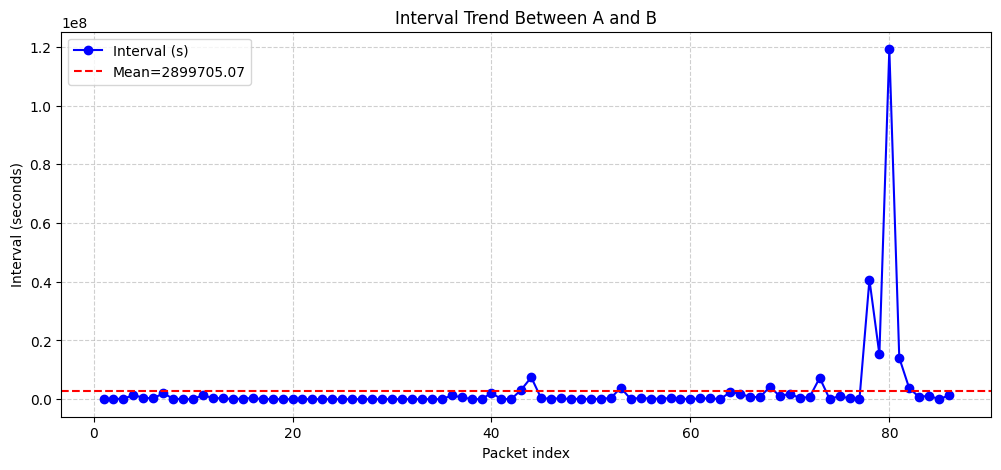

In [ ]:
# [TEST] Visualize data trend

tsList = grhttp_df.loc[7, 'dataList']
intervals = tsList
print(calc_bowley_skewness(intervals))
print(calc_median_absolute_deviation(intervals)) 
print(calc_autocorrelation_v2(intervals))
# print(rolling_score(intervals, calc_bowley_skewness, window_size=50))
# print(rolling_score(intervals, calc_median_absolute_deviation, window_size=15))
print(rolling_score(intervals, calc_autocorrelation_v2, window_size=15, agg="max"))

# X là số thứ tự gói (1..n-1)
x = np.arange(1, len(intervals) + 1)

# Vẽ biểu đồ đường
plt.figure(figsize=(12, 5))
plt.plot(x, intervals, marker='o', linestyle='-', color='blue', label="Interval (s)")
plt.axhline(np.mean(intervals), color='red', linestyle='--', label=f"Mean={np.mean(intervals):.2f}")

plt.xlabel("Packet index")
plt.ylabel("Interval (seconds)")
plt.title("Interval Trend Between A and B")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
# Aggregate score functions

def calc_timestamp_score(tsList):
    intervals = ts_to_interval(tsList)
    bowley_skewness = calc_bowley_skewness(intervals)
    mad = calc_median_absolute_deviation(intervals)
    autocorr = calc_autocorrelation_v2(intervals)

    score = (bowley_skewness + mad + autocorr) / 3
    return score

def calc_data_size_score(byteList):
    bowley_skewness = calc_bowley_skewness(byteList)
    mad = calc_median_absolute_deviation(byteList)

    score = (bowley_skewness + mad) / 2
    return score

In [ ]:
# Write score to Elasticsearch

index_name = "beacon_score_test_2"

mapping = {
    "mappings": {
        "properties": {
            "srcIP": {"type": "ip"},
            "dstIP": {"type": "ip"},
            "finalScore": {"type": "float"},
            "@timestamp": {"type": "date"},
        }
    }
}

# create index safely
conn.options(ignore_status=[400]).indices.create(index=index_name, body=mapping)

# add timestamp
df.loc[:, "timestamp"] = pd.Timestamp.now(tz="Asia/Bangkok")

# prepare bulk actions
actions = [
    {
        "_index": index_name,
        "_source": {
            "srcIP": row["srcIP"],
            "dstIP": row["dstIP"],
            "finalScore": float(row["finalScore"]),
            "@timestamp": row["timestamp"].isoformat(),
        },
    }
    for _, row in df.iterrows()
]

helpers.bulk(conn, actions)

(18, [])

# TEST

## CSV

In [ ]:
# 1. Read logs to dataframe
conn_df = pd.read_csv('zeek_conn_12h.csv')
http_df = pd.read_csv('zeek_http_12h.csv')
dns_df = pd.read_csv('zeek_dns_12h.csv')
ssl_df = pd.read_csv('zeek_ssl_12h.csv')

## PCAP

## Zeek log
- test_1: https://www.activecountermeasures.com/malware-of-the-day-zetaswitch-dns-http-multi-modal-c2/
- test_2: https://www.activecountermeasures.com/malware-of-the-day-multi-modal-c2-communication-numinon-c2/ 

In [101]:
path = "/home/mbelin/vdt/c2-beacon-detection/traffic/test_2/"
log_path = path + "log/"

In [102]:
# 1. Read logs to DataFrame

from elasticsearch import Elasticsearch, helpers
from elasticsearch.dsl import Search
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from pprint import pprint
import json
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object as pdhash
from datetime import datetime, timedelta
import pytz # Thư viện để xử lý múi giờ

pd.set_option('display.max_columns', None)
# Đọc file log Zeek vào DataFrame
def read_zeek_log(file_path):
    # Lấy tên cột từ dòng "#fields"
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#fields"):
                columns = line.strip().split("\t")[1:]  # bỏ "#fields"
                break

    # Đọc dữ liệu, bỏ các dòng metadata
    df = pd.read_csv(
        file_path,
        sep="\t",
        comment="#",      # bỏ các dòng bắt đầu bằng "#"
        names=columns,    # dùng tên cột lấy từ #fields
        na_values=["-"],  # thay "-" bằng NaN
    )
    return df


conn_df = read_zeek_log(log_path + "conn.log")
http_df = read_zeek_log(log_path + "http.log")
dns_df = read_zeek_log(log_path + "dns.log")
ssl_df = read_zeek_log(log_path + "ssl.log")

# if no ja3 column, add it with default value '0'
if 'ja3' not in ssl_df.columns:
    ssl_df['ja3'] = '0'

    
ssl_df['sni_matches_cert'] = ssl_df['sni_matches_cert'].map({'T': True})

In [103]:
# 2. Save dataframe to csv

conn_df.to_csv( path + 'conn.csv', index=False)
http_df.to_csv( path + 'http.csv', index=False)
dns_df.to_csv( path + 'dns.csv', index=False)
ssl_df.to_csv( path + 'ssl.csv', index=False)

In [116]:
# 3. Calc final score

# %%
# 1. remove logs where dstIP in whitelist
WHITELIST_IP = ['8.8.8.8', '1.1.1.1']
conn_df = conn_df.loc[~conn_df['id.resp_h'].isin(WHITELIST_IP)]

# %%
# 2. check common port
common_ports = {80, 443, 53, 22, 25, 21, 5353}

conn_df['rare_port'] = conn_df['id.resp_p'].apply(lambda x: 0 if x in common_ports else 1)

# %%
# group by srcIP, dstIP

rows = []

conn_df = conn_df.sort_values(by=['ts'])
conn_grouped = conn_df.groupby(['id.orig_h', 'id.resp_h', 'id.resp_p'])
for name, group in conn_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'dstPort': name[2],
        'timeList': group["ts"].tolist(),
        'dataList': group['orig_ip_bytes'].tolist(),
        'durList': [v for v in group['duration'].tolist() if pd.notna(v)],
        'rare_port': max(group['rare_port'].tolist()),
    })
grcon_df = pd.DataFrame(rows)

# %%
# 3. check IoC list for dstIP
with open('ioc_ip.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

grcon_df.loc[:, 'ip_ioc'] = np.where(grcon_df['dstIP'].isin(ioc_list), 1, 0)

# %%
# Calc Bowkey skewness and Median Absolute Deviation

# --- Lọc outlier bằng IQR ---
def remove_outliers_iqr(data, factor=1.5):
    # if len(data) < 5:
    #     return np.array(data)
    # q1, q3 = np.percentile(data, [25, 75])
    # iqr = q3 - q1
    # lower = q1 - factor * iqr
    # upper = q3 + factor * iqr
    # return data[(data >= lower) & (data <= upper)]

    return data

# --- Tính độ lệch Bowley (mức độ đối xứng của phân phối) ---
def calc_bowley_skewness(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    q1, q2, q3 = np.percentile(data, [25, 50, 75])
    if (q3 - q1) == 0:
        return 1.0
    bowley_skewness = (q3 + q1 - 2 * q2) / (q3 - q1)
    score = 1 - abs(bowley_skewness)  # 1 là đối xứng hoàn hảo
    return score

# --- Tính MAD (độ phân tán quanh trung vị) ---
def calc_median_absolute_deviation(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    cv_mad = mad / median if median != 0 else 0
    score = 1.0 / (1.0 + cv_mad)  # 1 là ổn định tuyệt đối
    return score

# --- Hàm tổng hợp theo cửa sổ (window-based) ---
def rolling_score(data, func, window_size=20, agg="median"):
    if len(data) < window_size:
        return func(np.array(data))
    
    scores = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = np.array(data[i:i+window_size])
        score = func(window)
        scores.append(score)
    
    if len(scores) == 0:
        return 0.0

    if agg == "median":
        return np.median(scores)
    elif agg == "mean":
        return np.mean(scores)
    elif agg == "max":
        return np.max(scores)
    else:
        raise ValueError("agg must be 'median', 'mean', or 'max'")

# Calc autocorrelation v2 using statsmodels
def calc_autocorrelation_v2(data: list) -> float:
    if len(data) < 5:
        return 0.0
    
    data = remove_outliers_iqr(np.array(data))

    if len(data) < 2 or np.var(data) == 0:
        return 1 # beacon deu

    nlags = len(data) // 2

    try:
        autocorr_values = acf(data, nlags=nlags, fft=True)
        autocorr_values = np.nan_to_num(autocorr_values, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        return 0.0

    if len(autocorr_values) < 2:
        return 0.0

    score = np.max(np.clip(autocorr_values[1:], 0, 1))  # chỉ quan tâm lag > 0
    return score

# %%
# save row with timeList length < 5 for the next analysis

# %%
# Calc features

def ts_to_interval(ts):
    return np.diff(ts)

# # time features
grcon_df['time_bskew'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grcon_df['time_mad'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grcon_df['time_acf'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

grcon_df['data_bskew'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['data_mad'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))

grcon_df['dur_bskew'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['dur_mad'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['dur_acf'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df

# %%
# merge grcon_df to final_df
# final_con = grcon_df.groupby(['srcIP', 'dstIP']).agg({
#     'time_bskew': 'max',
#     'time_mad': 'max',
#     'time_acf': 'max',
#     'data_bskew': 'max',
#     'data_mad': 'max',
#     'dur_bskew': 'max',
#     'dur_mad': 'max',
#     'dur_acf': 'max',
#     'rare_port': 'max',
#     'ip_ioc': 'max',
# }).reset_index()
# final_con.set_index(['srcIP', 'dstIP'], inplace=True)

final_con = grcon_df

final_con['time_score'] = final_con[['time_bskew', 'time_mad']].mean(axis=1)
final_con['time_score'] = final_con[['time_score', 'time_acf']].max(axis=1)

final_con['data_score'] = final_con[['data_bskew', 'data_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_bskew', 'dur_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_score', 'dur_acf']].max(axis=1)
final_con['conn_score'] = final_con[['time_score', 'data_score']].mean(axis=1)
# if dur_score > 0.6, increase final_score by 10% as a bonus, but not exceed 1.0
final_con['conn_score'] = np.where(final_con['dur_score'] > 0.6, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['rare_port'] == 1, final_con['conn_score'] * 1.1, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['ip_ioc'] == 1, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = final_con['conn_score'].clip(upper=1.0)

final_con['proto'] = np.nan

port_service_map = {
    21: 'FTP',
    22: 'SSH',
    23: 'Telnet',
    25: 'SMTP',
    53: 'DNS',
    80: 'HTTP',
    110: 'POP3',
    143: 'IMAP',
    443: 'HTTPS',
    445: 'SMB',
}

# for the same IP pair, if a dstPort conn_score > 0.8, at service to beacon_type
for index, row in final_con.iterrows():
    if row['conn_score'] > 0.8:
        service = port_service_map.get(row['dstPort'], float('nan'))
        # if pd.isna(row['proto']):
        final_con.at[index, 'proto'] = service
        # else:
            # if service not in final_con.at[index, 'proto'].split(', '):
                # final_con.at[index, 'proto'] += ', ' + service

# aggregate by srcIP, dstIP
final_con = final_con.groupby(['srcIP', 'dstIP']).agg({
    'conn_score': 'max',
    'rare_port': 'max',
    'ip_ioc': 'max',
    'proto': lambda x: ','.join(sorted(set(filter(pd.notna, x)))),
}).reset_index()

# only keep important columns
final_con = final_con[['srcIP', 'dstIP', 'conn_score', 'rare_port', 'ip_ioc', 'proto']]
final_con


# %%
# 3. check JA3
with open('ioc_ja3.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)

# %%
# group by srcIP, dstIP
rows = []
ssl_df = ssl_df.sort_values(by=['ts'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'id.resp_h'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'sni_matches_cert': max(group['sni_matches_cert'].tolist()),
    })
grssl_df = pd.DataFrame(rows)
grssl_df.set_index(['srcIP', 'dstIP'], inplace=True)

for index, row in ssl_df.iterrows():
    if pd.isna(row['sni_matches_cert']):
        ssl_df.at[index, 'sni_matches_cert'] = grssl_df.loc[(row['id.orig_h'], row['id.resp_h']), 'sni_matches_cert']


# %%
# 4. check SNI
# ssl_df.loc[:, 'sni_not_matched_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

def extract_domain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[-2:]) if len(parts) >= 2 else fqdn

SAFE_DOMAINS = [
    'google.com','gstatic.com','youtube.com','ggpht.com',
    'microsoft.com','windowsupdate.com','office.com','msftconnecttest.com',
    'apple.com','icloud.com','mzstatic.com',
    'facebook.com','fbcdn.net','instagram.com','whatsapp.net',
    'cloudflare.com','cdn.cloudflare.net',
    'dns.google','quad9.net','a.root-servers.net','b.root-servers.net','c.root-servers.net',
    'd.root-servers.net','e.root-servers.net','f.root-servers.net','g.root-servers.net',
    'h.root-servers.net','i.root-servers.net','j.root-servers.net','k.root-servers.net',
    'l.root-servers.net','m.root-servers.net'
] # service that not likely to be used for domain fronting

ssl_df = ssl_df[~(
    (ssl_df['sni_matches_cert'] == True) &
    (ssl_df['server_name'].apply(lambda x: extract_domain(x)).isin(SAFE_DOMAINS))
)]

# group by srcIP, server_name, sni_not_matched_cert
rows = []
ssl_df['sni_not_matches_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

ssl_df = ssl_df.sort_values(by=['ts'])
ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'server_name', 'sni_not_matches_cert'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'server_name': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'ja3_ioc': max(group['ja3_ioc'].tolist()),
        'sni_not_matched_cert': name[2],
    })
grssl_df = pd.DataFrame(rows)

# %%
# Calc features
grssl_df['time_bskew'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grssl_df['time_mad'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grssl_df['time_acf'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

# %%
# merge grssl_df to final_ssl
# get max of mean(time_bskew, time_mad) and time_acf
grssl_df['ssl_score'] = grssl_df[['time_bskew', 'time_mad']].mean(axis=1)
grssl_df['ssl_score'] = grssl_df[['ssl_score', 'time_acf']].max(axis=1)
# if ja3_ioc == 1, increase ssl_score by 20% as a bonus, but not exceed 1.0
grssl_df['ssl_score'] = np.where(grssl_df['ja3_ioc'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = np.where(grssl_df['sni_not_matched_cert'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = grssl_df['ssl_score'].clip(upper=1.0)

final_ssl = grssl_df.explode('dstIPList', ignore_index=True)
final_ssl = final_ssl.rename(columns={'dstIPList': 'dstIP'})
# final_ssl.set_index(['srcIP', 'dstIP'], inplace=True)
final_ssl = final_ssl[['srcIP', 'dstIP', 'ssl_score', 'ja3_ioc', 'sni_not_matched_cert']]

# %% [markdown]
# # http.log

# %%
# check User-Agent
http_df['null_user_agent'] = http_df['user_agent'].apply(lambda x: 1 if pd.isna(x) else 0)

# %%
# group by srcIP, Host
rows = []
http_df = http_df.sort_values(by=['ts'])
http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
http_grouped = http_df.groupby(['id.orig_h', 'host'])
for name, group in http_grouped:
    rows.append({
        'srcIP': name[0],
        'host': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'dataList': group['response_body_len'].tolist(),
        'null_user_agent': 1 if pd.isna(group['user_agent']).any() else 0
    })
grhttp_df = pd.DataFrame(rows)

# %%
# Calc features

grhttp_df['time_bskew'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grhttp_df['time_mad'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grhttp_df['time_acf'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grhttp_df['data_bskew'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grhttp_df['data_mad'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
# grhttp_df['data_acf'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

# %%
# merge grhttp_df to final_http

# get max of mean(time_bskew, time_mad) and time_acf
grhttp_df['time_score'] = grhttp_df[['time_bskew', 'time_mad']].mean(axis=1)
grhttp_df['time_score'] = grhttp_df[['time_score', 'time_acf']].max(axis=1)
# get mean of data_bskew and data_mad
grhttp_df['data_score'] = grhttp_df[['data_bskew', 'data_mad']].mean(axis=1)
# final score is mean of time_score and data_score
grhttp_df['http_score'] = (grhttp_df['time_score'] + grhttp_df['data_score']) / 2
# if null_user_agent == 1, increase http_score by 20% as a bonus, but not exceed 1.0
grhttp_df['http_score'] = np.where(grhttp_df['null_user_agent'] == 1, grhttp_df['http_score'] * 1.2, grhttp_df['http_score'])
grhttp_df['http_score'] = grhttp_df['http_score'].clip(upper=1.0)

final_http = grhttp_df.explode('dstIPList', ignore_index=True)
final_http = final_http.rename(columns={'dstIPList': 'dstIP'})
# final_http.set_index(['srcIP', 'dstIP'], inplace=True)
final_http = final_http[['srcIP', 'dstIP', 'http_score', 'null_user_agent']]

# %% [markdown]
# # dns.log

# %%
# remove logs with nan query
dns_df = dns_df[~pd.isna(dns_df['query'])]

# %%
dns_df.loc[:, 'domain'] = dns_df['query'].apply(lambda x: extract_domain(x))

def extract_subdomain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[:-2]) if len(parts) > 2 else ''

# group by srcIP, domain
rows = []
dns_df = dns_df.sort_values(by=['ts'])
dns_grouped = dns_df.groupby(['id.orig_h', 'domain'])
for name, group in dns_grouped:
    rows.append({
        'srcIP': name[0],
        'domain': name[1],
        'timeList': group["ts"].tolist(),
        'subdmList': group['query'].apply(lambda x: extract_subdomain(x)).tolist(),
        '%TXT/CNAME': sum(group['qtype_name'].isin(['TXT', 'CNAME'])),
        '%NXDOMAIN': sum(group['rcode_name'] == 'NXDOMAIN'),
    })

grdns_df = pd.DataFrame(rows)
grdns_df['%TXT/CNAME'] = grdns_df['%TXT/CNAME'] / grdns_df['timeList'].apply(len)
grdns_df['%NXDOMAIN'] = grdns_df['%NXDOMAIN'] / grdns_df['timeList'].apply(len)
grdns_df['%unique_subdm'] = grdns_df['subdmList'].apply(lambda x: len(set(x))) / grdns_df['timeList'].apply(len)
grdns_df['dm_avg_len'] = grdns_df['subdmList'].apply(lambda x: np.mean([len(s) for s in x]) if len(x) > 0 else 0) + grdns_df['domain'].apply(lambda x: len(x))

# %%
# Calc features
grdns_df['time_bskew'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grdns_df['time_mad'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grdns_df['time_acf'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

# %%
grdns_df['high_TXT/CNAME_ratio'] = np.where(grdns_df['%TXT/CNAME'] > 0.5, 1, 0)
grdns_df['high_NXDOMAIN_ratio'] = np.where(grdns_df['%NXDOMAIN'] > 0.5, 1, 0)
grdns_df['high_unique_subdm_ratio'] = np.where(grdns_df['%unique_subdm'] > 0.5, 1, 0)
grdns_df['long_dm_avg_len'] = np.where(grdns_df['dm_avg_len'] > 40, 1, 0)

grdns_df['dns_score'] = grdns_df[['time_bskew', 'time_mad']].mean(axis=1)
grdns_df['dns_score'] = grdns_df[['dns_score', 'time_acf']].max(axis=1)
# if %TXT/CNAME > 0.5 and number of query > 10, increase dns_score by 10% as a bonus, but not exceed 1.0
grdns_df['dns_score'] = np.where(grdns_df['high_TXT/CNAME_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_NXDOMAIN_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_unique_subdm_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['long_dm_avg_len'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = grdns_df['dns_score'].clip(upper=1.0)

final_dns = grdns_df.explode('domain', ignore_index=True)
final_dns = final_dns.rename(columns={'domain': 'dstIP'})
# final_dns.set_index(['srcIP', 'dstIP'], inplace=True)
final_dns = final_dns[['srcIP', 'dstIP', 'dns_score', 'high_TXT/CNAME_ratio', 'high_NXDOMAIN_ratio', 'high_unique_subdm_ratio', 'long_dm_avg_len']]

# %%
def merge_with_reason(base_df, new_df, score_col, reason_map):
    # Nếu base_df đã có score_col thì xóa (tránh sinh _x/_y)
    if score_col in base_df.columns:
        base_df = base_df.drop(columns=[score_col])

    # Lấy các cột cần merge
    cols_to_merge = ['srcIP', 'dstIP', score_col]
    if isinstance(reason_map, dict):
        cols_to_merge += list(reason_map.keys())

    merged = base_df.merge(
        new_df[cols_to_merge],
        on=['srcIP', 'dstIP'],
        how='outer'
    )

    merged['reason'] = merged.get('reason', '').fillna('')
    merged['beacon_type'] = merged.get('beacon_type', '').fillna('')

    for col, msg in reason_map.items():
        if col in merged.columns:
            if pd.api.types.is_string_dtype(merged[col]):
                # Nếu cột là chuỗi -> nối giá trị chuỗi
                merged.loc[merged[col].notna(), 'beacon_type'] = (
                    merged['beacon_type'].astype(str).str.strip() +
                    np.where(merged['beacon_type'].astype(bool), ', ', '') +
                    merged[col].astype(str)
                )
            else:
                # Nếu cột là flag 0/1 -> thêm message khi flag = 1
                merged.loc[merged[col] == 1, 'reason'] = (
                    merged['reason'].astype(str).str.strip() +
                    np.where(merged['reason'].astype(bool), '; ', '') +
                    msg
                )

    # 👉 Xóa cột flag/mô tả sau khi vòng for kết thúc
    merged = merged.drop(columns=reason_map.keys(), errors='ignore')

    return merged

final_df = pd.DataFrame(columns=['srcIP', 'dstIP', 'conn_score', 'ssl_score', 'http_score', 'dns_score', 'reason', 'beacon_type'])

# 1️⃣ Connection
final_df = merge_with_reason(
    final_df, final_con,
    score_col='conn_score',
    reason_map={
        'rare_port': 'Rare port used',
        'ip_ioc': 'IP in IOC list',
        'proto': 'Sus service'
    }
)

# 2️⃣ SSL
final_df = merge_with_reason(
    final_df, final_ssl,
    score_col='ssl_score',
    reason_map={
        'ja3_ioc': 'JA3 in IOC list',
        'sni_not_matched_cert': 'SNI not matched with certificate'
    }
)

# 3️⃣ HTTP
final_df = merge_with_reason(
    final_df, final_http,
    score_col='http_score',
    reason_map={
        'null_user_agent': 'Null User-Agent'
    }
)

# 4️⃣ DNS
final_df = merge_with_reason(
    final_df, final_dns,
    score_col='dns_score',
    reason_map={
        'high_TXT/CNAME_ratio': 'High TXT/CNAME ratio',
        'high_NXDOMAIN_ratio': 'High NXDOMAIN ratio',
        'high_unique_subdm_ratio': 'High unique subdomain ratio',
        'long_dm_avg_len': 'Long domain average length'
    }
)


final_df['final_score'] = final_df[['conn_score', 'ssl_score', 'http_score', 'dns_score']].max(axis=1)
# remove row with final_score = 0
final_df = final_df[final_df['final_score'] > 0]

# if final score > 0.8, set beacon types based on scores > 0.7
def determine_beacon_type(row):
    types = []
    # if pd.notna(row['conn_score']) and row['conn_score'] > 0.9:
    #     types.append('Other')
    if pd.notna(row['ssl_score']) and row['ssl_score'] > 0.8:
        types.append('SSL')
    if pd.notna(row['http_score']) and row['http_score'] > 0.8:
        types.append('HTTP')
    if pd.notna(row['dns_score']) and row['dns_score'] > 0.8:
        types.append('DNS')
    if (pd.isna(row['ssl_score']) and pd.isna(row['http_score']) and pd.isna(row['dns_score'])) and row['conn_score'] > 0.9:
        types.append('Other')
    return ', '.join(types) if types else ''

beacontype = final_df.apply(determine_beacon_type, axis=1)

final_df['beacon_type'] = np.where(
    (final_df['beacon_type'].notna()),
    final_df['beacon_type'] + ',' + beacontype,
    beacontype
)

final_df['beacon_type'] = final_df['beacon_type'].str.split(',').apply(lambda x: ', '.join(sorted(set([i for i in x if i != '']))))

final_df['avg_score'] = final_df[['ssl_score', 'http_score', 'dns_score']].mean(axis=1)
final_df.sort_values(by=['final_score', 'avg_score'], ascending=False, inplace=True)

# reset index
final_df = final_df.reset_index(drop=True)

/tmp/ipykernel_2094381/3703985383.py:199: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HTTPS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_con.at[index, 'proto'] = service


In [119]:
# 4. Save final score to csv

final_df.to_csv(f'{path}/final_df.csv', index=False)
final_df.head(30)

,srcIP,dstIP,reason,beacon_type,conn_score,ssl_score,http_score,dns_score,final_score,avg_score
0,192.168.2.115,142.251.33.163,,HTTP,1.000000,NaN,0.947006,NaN,1.000000,0.947006
1,192.168.2.115,142.251.41.35,,HTTP,1.000000,NaN,0.947006,NaN,1.000000,0.947006
2,192.168.2.115,192.168.2.255,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
3,192.168.2.126,224.0.0.251,,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
4,192.168.2.13,192.168.2.255,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
5,192.168.2.13,224.0.0.252,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
6,192.168.2.181,239.255.255.250,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
7,192.168.2.181,255.255.255.255,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
8,192.168.2.206,192.168.2.255,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
9,fe80::2898:76ed:1cf1:d4cd,ff02::1,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN


In [109]:
conn_df[conn_df['id.resp_h'] == '64.23.212.29']

# final_df[final_df['dstIP'] == '64.23.212.29']

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,rare_port
0,1.751804e+09,CSogxf3d5nnongfCzb,192.168.2.115,52537,64.23.212.29,6767,tcp,ssl,0.665412,1746.0,2772.0,SF,T,F,0,ShADadFf,9,625,11,3224,NaN,1
11,1.751804e+09,CUMuZYpVUhu85Fd57,192.168.2.115,52539,64.23.212.29,6767,tcp,ssl,0.740437,1746.0,2772.0,SF,T,F,0,ShADadFfRRR,11,705,11,3224,NaN,1
75,1.751804e+09,C7bS6Z3mX98qOxiLLh,192.168.2.115,52540,64.23.212.29,6767,tcp,ssl,0.752028,1746.0,2885.0,SF,T,F,0,ShADadFf,9,625,11,3337,NaN,1
76,1.751804e+09,Ck19tP2AN5RhkEbU35,192.168.2.115,52541,64.23.212.29,6767,tcp,ssl,0.806673,2001.0,2704.0,SF,T,F,0,ShADadFfRRR,11,960,11,3156,NaN,1
107,1.751805e+09,Cukeic3k23H1EHF126,192.168.2.115,52545,64.23.212.29,6767,tcp,ssl,0.663109,1746.0,2772.0,SF,T,F,0,ShADadFf,9,625,11,3224,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12122,1.751889e+09,Cbz8MJ1AxH3Zjm6aLe,192.168.2.115,55032,64.23.212.29,7676,tcp,ssl,0.690313,1746.0,2772.0,SF,T,F,0,ShADadFf,9,625,11,3224,NaN,1
12129,1.751889e+09,C8C6Md4MntYqNrLsi3,192.168.2.115,55033,64.23.212.29,7676,tcp,ssl,0.740199,1746.0,2772.0,SF,T,F,0,ShADadFf,9,625,11,3224,NaN,1
12150,1.751890e+09,Caw5l5nSL21RkKkq5,192.168.2.115,55035,64.23.212.29,7676,tcp,ssl,0.586346,1746.0,2772.0,SF,T,F,0,ShADadFf,9,625,11,3224,NaN,1
12193,1.751890e+09,CwvkVI1F0qkAmrVfr2,192.168.2.115,55037,64.23.212.29,7676,tcp,ssl,0.816440,1746.0,2772.0,SF,T,F,0,ShADadFf,9,625,11,3224,NaN,1


## SecOni

In [ ]:
path = "/home/mbelin/vdt/c2-beacon-detection/traffic/test_2/"

In [ ]:
# # Read logs to dataframe

from elasticsearch import Elasticsearch, helpers
from elasticsearch.dsl import Search
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from pprint import pprint
import json
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object as pdhash
from datetime import datetime, timedelta
import pytz # Thư viện để xử lý múi giờ

pd.set_option('display.max_columns', None)

# Establish connection to Elasticsearch
conn = Elasticsearch(
    ['https://192.168.145.101:9200'], 
    ca_certs=False, 
    verify_certs=False,
    basic_auth=('jupyter', 'jupyter@seconi.com'),
    # basic_auth=('nialliceh@gmail.com', 'nialliceh3108'),
)

print(conn.info())
# print(conn.indices.get_data_stream(name="logs-zeek*"))

zlog = Search(using=conn, index='logs-zeek-so')

conn_log = zlog.query("term", **{"event.dataset": "zeek.conn"})
http_log = zlog.query("term", **{"event.dataset": "zeek.http"})
dns_log = zlog.query("term", **{"event.dataset": "zeek.dns"})
ssl_log = zlog.query("term", **{"event.dataset": "zeek.ssl"})

conn_12h = conn_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
http_12h = http_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
dns_12h = dns_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})
ssl_12h = ssl_log.filter('range', **{'@timestamp': {'gte': 'now-12h', 'lt': 'now'}})

conn_df = pd.DataFrame()
for hit in conn_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    conn_df = pd.concat([conn_df, row], ignore_index=True)

http_df = pd.DataFrame()
for hit in http_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    http_df = pd.concat([http_df, row], ignore_index=True)

dns_df = pd.DataFrame()
for hit in dns_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    dns_df = pd.concat([dns_df, row], ignore_index=True)

ssl_df = pd.DataFrame()
for hit in ssl_12h.scan():
    data = hit.to_dict()['message']
    data = json.loads(data)
    row = pd.DataFrame([data])
    ssl_df = pd.concat([ssl_df, row], ignore_index=True)


In [ ]:
# 2. Save dataframe to csv

conn_df.to_csv( path + 'conn.csv', index=False)
http_df.to_csv( path + 'http.csv', index=False)
dns_df.to_csv( path + 'dns.csv', index=False)
ssl_df.to_csv( path + 'ssl.csv', index=False)

In [ ]:
# 3. Calc final score

# %%
# 1. remove logs where dstIP in whitelist
WHITELIST_IP = ['8.8.8.8', '1.1.1.1']
conn_df = conn_df.loc[~conn_df['id.resp_h'].isin(WHITELIST_IP)]

# %%
# 2. check common port
common_ports = {80, 443, 53, 22, 25, 21, 5353}

conn_df['rare_port'] = conn_df['id.resp_p'].apply(lambda x: 0 if x in common_ports else 1)

# %%
# group by srcIP, dstIP

rows = []

conn_df = conn_df.sort_values(by=['ts'])
conn_grouped = conn_df.groupby(['id.orig_h', 'id.resp_h', 'id.resp_p'])
for name, group in conn_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'dstPort': name[2],
        'timeList': group["ts"].tolist(),
        'dataList': group['orig_ip_bytes'].tolist(),
        'durList': [v for v in group['duration'].tolist() if pd.notna(v)],
        'rare_port': max(group['rare_port'].tolist()),
    })
grcon_df = pd.DataFrame(rows)

# %%
# 3. check IoC list for dstIP
with open('ioc_ip.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

grcon_df.loc[:, 'ip_ioc'] = np.where(grcon_df['dstIP'].isin(ioc_list), 1, 0)

# %%
# Calc Bowkey skewness and Median Absolute Deviation

# --- Lọc outlier bằng IQR ---
def remove_outliers_iqr(data, factor=1.5):
    if len(data) < 5:
        return np.array(data)
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return data[(data >= lower) & (data <= upper)]

# --- Tính độ lệch Bowley (mức độ đối xứng của phân phối) ---
def calc_bowley_skewness(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    q1, q2, q3 = np.percentile(data, [25, 50, 75])
    if (q3 - q1) == 0:
        return 1.0
    bowley_skewness = (q3 + q1 - 2 * q2) / (q3 - q1)
    score = 1 - abs(bowley_skewness)  # 1 là đối xứng hoàn hảo
    return score

# --- Tính MAD (độ phân tán quanh trung vị) ---
def calc_median_absolute_deviation(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    cv_mad = mad / median if median != 0 else 0
    score = 1.0 / (1.0 + cv_mad)  # 1 là ổn định tuyệt đối
    return score

# --- Hàm tổng hợp theo cửa sổ (window-based) ---
def rolling_score(data, func, window_size=20, agg="median"):
    if len(data) < window_size:
        return func(np.array(data))
    
    scores = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = np.array(data[i:i+window_size])
        score = func(window)
        scores.append(score)
    
    if len(scores) == 0:
        return 0.0

    if agg == "median":
        return np.median(scores)
    elif agg == "mean":
        return np.mean(scores)
    elif agg == "max":
        return np.max(scores)
    else:
        raise ValueError("agg must be 'median', 'mean', or 'max'")

# Calc autocorrelation v2 using statsmodels
def calc_autocorrelation_v2(data: list) -> float:
    if len(data) < 5:
        return 0.0
    
    data = remove_outliers_iqr(np.array(data))

    if len(data) < 2 or np.var(data) == 0:
        return 1 # beacon deu

    nlags = len(data) // 2

    try:
        autocorr_values = acf(data, nlags=nlags, fft=True)
        autocorr_values = np.nan_to_num(autocorr_values, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        return 0.0

    if len(autocorr_values) < 2:
        return 0.0

    score = np.max(np.clip(autocorr_values[1:], 0, 1))  # chỉ quan tâm lag > 0
    return score

# %%
# save row with timeList length < 5 for the next analysis

# %%
# Calc features

def ts_to_interval(ts):
    return np.diff(ts)

# # time features
grcon_df['time_bskew'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grcon_df['time_mad'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grcon_df['time_acf'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

grcon_df['data_bskew'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['data_mad'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))

grcon_df['dur_bskew'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['dur_mad'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['dur_acf'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df

# %%
# merge grcon_df to final_df
final_con = grcon_df.groupby(['srcIP', 'dstIP']).agg({
    'time_bskew': 'max',
    'time_mad': 'max',
    'time_acf': 'max',
    'data_bskew': 'max',
    'data_mad': 'max',
    'dur_bskew': 'max',
    'dur_mad': 'max',
    'dur_acf': 'max',
    'rare_port': 'max',
    'ip_ioc': 'max',
}).reset_index()
# final_con.set_index(['srcIP', 'dstIP'], inplace=True)
final_con['time_score'] = final_con[['time_bskew', 'time_mad']].mean(axis=1)
final_con['time_score'] = final_con[['time_score', 'time_acf']].max(axis=1)

final_con['data_score'] = final_con[['data_bskew', 'data_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_bskew', 'dur_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_score', 'dur_acf']].max(axis=1)
final_con['conn_score'] = final_con[['time_score', 'data_score']].mean(axis=1)
# if dur_score > 0.6, increase final_score by 10% as a bonus, but not exceed 1.0
final_con['conn_score'] = np.where(final_con['dur_score'] > 0.6, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['rare_port'] == 1, final_con['conn_score'] * 1.1, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['ip_ioc'] == 1, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = final_con['conn_score'].clip(upper=1.0)
# only keep important columns
final_con = final_con[['srcIP', 'dstIP', 'conn_score', 'rare_port', 'ip_ioc']]
final_con


# %%
# 3. check JA3
with open('ioc_ja3.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)

# %%
# group by srcIP, dstIP
rows = []
ssl_df = ssl_df.sort_values(by=['ts'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'id.resp_h'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'sni_matches_cert': max(group['sni_matches_cert'].tolist()),
    })
grssl_df = pd.DataFrame(rows)
grssl_df.set_index(['srcIP', 'dstIP'], inplace=True)

for index, row in ssl_df.iterrows():
    if pd.isna(row['sni_matches_cert']):
        ssl_df.at[index, 'sni_matches_cert'] = grssl_df.loc[(row['id.orig_h'], row['id.resp_h']), 'sni_matches_cert']


# %%
# 4. check SNI
# ssl_df.loc[:, 'sni_not_matched_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

def extract_domain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[-2:]) if len(parts) >= 2 else fqdn

SAFE_DOMAINS = [
    'google.com','gstatic.com','youtube.com','ggpht.com',
    'microsoft.com','windowsupdate.com','office.com','msftconnecttest.com',
    'apple.com','icloud.com','mzstatic.com',
    'facebook.com','fbcdn.net','instagram.com','whatsapp.net',
    'cloudflare.com','cdn.cloudflare.net',
    'dns.google','quad9.net','a.root-servers.net','b.root-servers.net','c.root-servers.net',
    'd.root-servers.net','e.root-servers.net','f.root-servers.net','g.root-servers.net',
    'h.root-servers.net','i.root-servers.net','j.root-servers.net','k.root-servers.net',
    'l.root-servers.net','m.root-servers.net'
] # service that not likely to be used for domain fronting

ssl_df = ssl_df[~(
    (ssl_df['sni_matches_cert'] == True) &
    (ssl_df['server_name'].apply(lambda x: extract_domain(x)).isin(SAFE_DOMAINS))
)]

# group by srcIP, server_name, sni_not_matched_cert
rows = []
ssl_df['sni_not_matches_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

ssl_df = ssl_df.sort_values(by=['ts'])
ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'server_name', 'sni_not_matches_cert'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'server_name': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'ja3_ioc': max(group['ja3_ioc'].tolist()),
        'sni_not_matched_cert': name[2],
    })
grssl_df = pd.DataFrame(rows)

# %%
# Calc features
grssl_df['time_bskew'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grssl_df['time_mad'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grssl_df['time_acf'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

# %%
# merge grssl_df to final_ssl
# get max of mean(time_bskew, time_mad) and time_acf
grssl_df['ssl_score'] = grssl_df[['time_bskew', 'time_mad']].mean(axis=1)
grssl_df['ssl_score'] = grssl_df[['ssl_score', 'time_acf']].max(axis=1)
# if ja3_ioc == 1, increase ssl_score by 20% as a bonus, but not exceed 1.0
grssl_df['ssl_score'] = np.where(grssl_df['ja3_ioc'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = np.where(grssl_df['sni_not_matched_cert'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = grssl_df['ssl_score'].clip(upper=1.0)

final_ssl = grssl_df.explode('dstIPList', ignore_index=True)
final_ssl = final_ssl.rename(columns={'dstIPList': 'dstIP'})
# final_ssl.set_index(['srcIP', 'dstIP'], inplace=True)
final_ssl = final_ssl[['srcIP', 'dstIP', 'ssl_score', 'ja3_ioc', 'sni_not_matched_cert']]

# %% [markdown]
# # http.log

# %%
# check User-Agent
http_df['null_user_agent'] = http_df['user_agent'].apply(lambda x: 1 if pd.isna(x) else 0)

# %%
# group by srcIP, Host
rows = []
http_df = http_df.sort_values(by=['ts'])
http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
http_grouped = http_df.groupby(['id.orig_h', 'host'])
for name, group in http_grouped:
    rows.append({
        'srcIP': name[0],
        'host': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'dataList': group['response_body_len'].tolist(),
        'null_user_agent': 1 if pd.isna(group['user_agent']).any() else 0
    })
grhttp_df = pd.DataFrame(rows)

# %%
# Calc features

grhttp_df['time_bskew'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grhttp_df['time_mad'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grhttp_df['time_acf'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grhttp_df['data_bskew'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grhttp_df['data_mad'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
# grhttp_df['data_acf'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

# %%
# merge grhttp_df to final_http

# get max of mean(time_bskew, time_mad) and time_acf
grhttp_df['time_score'] = grhttp_df[['time_bskew', 'time_mad']].mean(axis=1)
grhttp_df['time_score'] = grhttp_df[['time_score', 'time_acf']].max(axis=1)
# get mean of data_bskew and data_mad
grhttp_df['data_score'] = grhttp_df[['data_bskew', 'data_mad']].mean(axis=1)
# final score is mean of time_score and data_score
grhttp_df['http_score'] = (grhttp_df['time_score'] + grhttp_df['data_score']) / 2
# if null_user_agent == 1, increase http_score by 20% as a bonus, but not exceed 1.0
grhttp_df['http_score'] = np.where(grhttp_df['null_user_agent'] == 1, grhttp_df['http_score'] * 1.2, grhttp_df['http_score'])
grhttp_df['http_score'] = grhttp_df['http_score'].clip(upper=1.0)

final_http = grhttp_df.explode('dstIPList', ignore_index=True)
final_http = final_http.rename(columns={'dstIPList': 'dstIP'})
# final_http.set_index(['srcIP', 'dstIP'], inplace=True)
final_http = final_http[['srcIP', 'dstIP', 'http_score', 'null_user_agent']]

# %% [markdown]
# # dns.log

# %%
# remove logs with nan query
dns_df = dns_df[~pd.isna(dns_df['query'])]

# %%
dns_df.loc[:, 'domain'] = dns_df['query'].apply(lambda x: extract_domain(x))

def extract_subdomain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[:-2]) if len(parts) > 2 else ''

# group by srcIP, domain
rows = []
dns_df = dns_df.sort_values(by=['ts'])
dns_grouped = dns_df.groupby(['id.orig_h', 'domain'])
for name, group in dns_grouped:
    rows.append({
        'srcIP': name[0],
        'domain': name[1],
        'timeList': group["ts"].tolist(),
        'subdmList': group['query'].apply(lambda x: extract_subdomain(x)).tolist(),
        '%TXT/CNAME': sum(group['qtype_name'].isin(['TXT', 'CNAME'])),
        '%NXDOMAIN': sum(group['rcode_name'] == 'NXDOMAIN'),
    })

grdns_df = pd.DataFrame(rows)
grdns_df['%TXT/CNAME'] = grdns_df['%TXT/CNAME'] / grdns_df['timeList'].apply(len)
grdns_df['%NXDOMAIN'] = grdns_df['%NXDOMAIN'] / grdns_df['timeList'].apply(len)
grdns_df['%unique_subdm'] = grdns_df['subdmList'].apply(lambda x: len(set(x))) / grdns_df['timeList'].apply(len)
grdns_df['dm_avg_len'] = grdns_df['subdmList'].apply(lambda x: np.mean([len(s) for s in x]) if len(x) > 0 else 0) + grdns_df['domain'].apply(lambda x: len(x))

# %%
# Calc features
grdns_df['time_bskew'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grdns_df['time_mad'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grdns_df['time_acf'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

# %%
grdns_df['high_TXT/CNAME_ratio'] = np.where(grdns_df['%TXT/CNAME'] > 0.5, 1, 0)
grdns_df['high_NXDOMAIN_ratio'] = np.where(grdns_df['%NXDOMAIN'] > 0.5, 1, 0)
grdns_df['high_unique_subdm_ratio'] = np.where(grdns_df['%unique_subdm'] > 0.5, 1, 0)
grdns_df['long_dm_avg_len'] = np.where(grdns_df['dm_avg_len'] > 40, 1, 0)

grdns_df['dns_score'] = grdns_df[['time_bskew', 'time_mad']].mean(axis=1)
grdns_df['dns_score'] = grdns_df[['dns_score', 'time_acf']].max(axis=1)
# if %TXT/CNAME > 0.5 and number of query > 10, increase dns_score by 10% as a bonus, but not exceed 1.0
grdns_df['dns_score'] = np.where(grdns_df['high_TXT/CNAME_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_NXDOMAIN_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_unique_subdm_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['long_dm_avg_len'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = grdns_df['dns_score'].clip(upper=1.0)

final_dns = grdns_df.explode('domain', ignore_index=True)
final_dns = final_dns.rename(columns={'domain': 'dstIP'})
# final_dns.set_index(['srcIP', 'dstIP'], inplace=True)
final_dns = final_dns[['srcIP', 'dstIP', 'dns_score', 'high_TXT/CNAME_ratio', 'high_NXDOMAIN_ratio', 'high_unique_subdm_ratio', 'long_dm_avg_len']]

# %%
def merge_with_reason(base_df, new_df, score_col, reason_map):
    """
    Hợp nhất DataFrame phát hiện beacon theo IP pair.
    - Giữ lại duy nhất một score_col.
    - Gộp reason nếu nhiều điều kiện match.
    """
    # Nếu base_df đã có score_col thì xóa (tránh sinh _x/_y)
    if score_col in base_df.columns:
        base_df = base_df.drop(columns=[score_col])

    # Merge theo IP pair
    merged = base_df.merge(
        new_df[['srcIP', 'dstIP', score_col] + list(reason_map.keys())],
        on=['srcIP', 'dstIP'],
        how='outer'
    )

    # Bổ sung cột reason nếu thiếu
    merged['reason'] = merged['reason'].fillna('')

    # Thêm mô tả vào reason nếu flag = 1
    for col, msg in reason_map.items():
        merged.loc[merged[col] == 1, 'reason'] = (
            merged['reason'].astype(str).str.strip() +
            np.where(merged['reason'].astype(bool), '; ', '') +
            msg
        )

    # Xóa cột flag sau khi xử lý
    merged = merged.drop(columns=reason_map.keys())

    return merged

final_df = pd.DataFrame(columns=['srcIP', 'dstIP', 'conn_score', 'ssl_score', 'http_score', 'dns_score', 'reason'])

# 1️⃣ Connection
final_df = merge_with_reason(
    final_df, final_con,
    score_col='conn_score',
    reason_map={
        'rare_port': 'Rare port used',
        'ip_ioc': 'IP in IOC list'
    }
)

# 2️⃣ SSL
final_df = merge_with_reason(
    final_df, final_ssl,
    score_col='ssl_score',
    reason_map={
        'ja3_ioc': 'JA3 in IOC list',
        'sni_not_matched_cert': 'SNI not matched with certificate'
    }
)

# 3️⃣ HTTP
final_df = merge_with_reason(
    final_df, final_http,
    score_col='http_score',
    reason_map={
        'null_user_agent': 'Null User-Agent'
    }
)

# 4️⃣ DNS
final_df = merge_with_reason(
    final_df, final_dns,
    score_col='dns_score',
    reason_map={
        'high_TXT/CNAME_ratio': 'High TXT/CNAME ratio',
        'high_NXDOMAIN_ratio': 'High NXDOMAIN ratio',
        'high_unique_subdm_ratio': 'High unique subdomain ratio',
        'long_dm_avg_len': 'Long domain average length'
    }
)


final_df['final_score'] = final_df[['conn_score', 'ssl_score', 'http_score', 'dns_score']].max(axis=1)
# remove row with final_score = 0
final_df = final_df[final_df['final_score'] > 0]

# set beacon types based on scores > 0.7
def determine_beacon_type(row):
    types = []
    if pd.notna(row['conn_score']) and row['conn_score'] > 0.7:
        types.append('Other')
    if pd.notna(row['ssl_score']) and row['ssl_score'] > 0.7:
        types.append('SSL')
    if pd.notna(row['http_score']) and row['http_score'] > 0.7:
        types.append('HTTP')
    if pd.notna(row['dns_score']) and row['dns_score'] > 0.7:
        types.append('DNS')
    return ', '.join(types) if types else 'Low score'

final_df['beacon_type'] = final_df.apply(determine_beacon_type, axis=1)
final_df.sort_values(by='final_score', ascending=False, inplace=True)
final_df = final_df.reset_index()

In [ ]:
# 4. Save final score to csv

final_df.to_csv(f'{path}/final_df.csv', index=False)
final_df.head(20)

## Docker ELK (simulated traffic)
- test_3: sliver http (linux + windows) -> delay 10, jitter 8 -> 15h 7/10/2025 : 17h 7/10/2025
- test_4: sliver mtls (windows) -> delay 5, jitter 3 -> 23h 6/10/2025 : 8h 7/10/2025

In [120]:
path = "/home/mbelin/vdt/c2-beacon-detection/traffic/test_3/"

In [121]:
# 1. Read log to DataFrame

from elasticsearch import Elasticsearch, helpers
from elasticsearch.dsl import Search
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from pprint import pprint
import json
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pandas.util import hash_pandas_object as pdhash
from datetime import datetime, timedelta
import pytz # Thư viện để xử lý múi giờ

pd.set_option('display.max_columns', None)

# %%
# Establish connection to Elasticsearch
conn = Elasticsearch(
    # ['https://192.168.145.101:9200'], 
    ['http://localhost:9200'],
    # ca_certs=False, 
    # verify_certs=False,
    # basic_auth=('jupyter', 'jupyter@seconi.com'),
    # basic_auth=('nialliceh@gmail.com', 'nialliceh3108'),
    basic_auth=('analyzer_internal', 'analyzer'),
)

print(conn.info())
# print(conn.indices.get_data_stream(name="logs-zeek*"))

# %%
# --- Search across all filebeat Zeek indices ---
zlog = Search(using=conn, index="filebeat-*")

# --- Define Zeek datasets ---
datasets = {
    "conn": "zeek.connection",
    "http": "zeek.http",
    "dns": "zeek.dns",
    "ssl": "zeek.ssl"
}

# 1. Định nghĩa múi giờ của bạn (Việt Nam, UTC+7)
local_tz = pytz.timezone("Asia/Ho_Chi_Minh")

# 2. Định nghĩa thời gian bắt đầu và kết thúc một cách tường minh
start_time_local = local_tz.localize(datetime(2025, 10, 7, 15, 0, 0))
end_time_local = local_tz.localize(datetime(2025, 10, 7, 16, 0, 0))

print(f"Querying data from {start_time_local.isoformat()} to {end_time_local.isoformat()}")


dfs = {}  # store DataFrames for each type

for name, dataset in datasets.items():
    print(f"Fetching {dataset} logs...")

    query = (
        zlog.query("term", **{"event.dataset": dataset})
            .filter("range", **{
                "@timestamp": {
                    "gte": start_time_local.isoformat(),
                    "lt": end_time_local.isoformat()
                }
            })
    )

    # Collect results
    rows = []
    for hit in query.scan():
        doc = hit.to_dict()
        rows.append(doc)   # keep full parsed document (all ECS + Zeek fields)

    # Convert to DataFrame
    if rows:
        df = pd.json_normalize(rows, sep='.')
        dfs[name] = df
        print(f"✅ {dataset}: {len(df)} rows, {len(df.columns)} columns")
    else:
        print(f"⚠️ {dataset}: no data found")

for name, df in dfs.items():
    df['@timestamp'] = pd.to_datetime(df['@timestamp']).dt.tz_convert('Asia/Bangkok')
    df['ts'] = df['@timestamp'].astype('int64') / 1e9

{'name': 'elasticsearch', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'Pu_iQyxxRKaCyWAkyvdUmA', 'version': {'number': '9.1.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'ca1a70216fbdefbef3c65b1dff04903ea5964ef5', 'build_date': '2025-08-11T15:04:41.449624592Z', 'build_snapshot': False, 'lucene_version': '10.2.2', 'minimum_wire_compatibility_version': '8.19.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'}
Querying data from 2025-10-07T15:00:00+07:00 to 2025-10-07T16:00:00+07:00
Fetching zeek.connection logs...
✅ zeek.connection: 837 rows, 60 columns
Fetching zeek.http logs...
✅ zeek.http: 357 rows, 69 columns
Fetching zeek.dns logs...
✅ zeek.dns: 546 rows, 65 columns
Fetching zeek.ssl logs...
✅ zeek.ssl: 158 rows, 65 columns


In [122]:
# 2. Save dataframe to csv

dfs['conn'].to_csv( path + 'conn.csv', index=False)
dfs['http'].to_csv( path + 'http.csv', index=False)
dfs['dns'].to_csv( path + 'dns.csv', index=False)
dfs['ssl'].to_csv( path + 'ssl.csv', index=False)

In [123]:
# 2.5 convert to zeek labels
conn_df = dfs['conn'][['ts', 'source.ip', 'destination.ip', 'destination.port', 'event.duration', 'source.bytes']]
conn_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'id.resp_p', 'duration', 'orig_ip_bytes']
conn_df.head()

ssl_df = dfs['ssl'][['ts', 'source.ip', 'destination.ip', 'zeek.ssl.sni_matches_cert', 'zeek.ssl.server.name', 'tls.client.ja3']]
ssl_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'sni_matches_cert', 'server_name', 'ja3']
ssl_df.head()

http_df = dfs['http'][['ts', 'source.ip', 'destination.ip', 'url.domain', 'http.response.body.bytes', 'user_agent.original']]
http_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'host', 'response_body_len', 'user_agent']
http_df.head()

dns_df = dfs['dns'][['ts', 'source.ip', 'destination.ip', 'zeek.dns.query', 'zeek.dns.qtype_name', 'zeek.dns.rcode_name']]
dns_df.columns = ['ts', 'id.orig_h', 'id.resp_h', 'query', 'qtype_name', 'rcode_name']
dns_df.head()

,ts,id.orig_h,id.resp_h,query,qtype_name,rcode_name
0,1.759827e+09,192.168.28.1,224.0.0.251,_ipp._tcp.local,PTR,NaN
1,1.759827e+09,fe80::250:56ff:fec0:9,ff02::fb,_ipp._tcp.local,PTR,NaN
2,1.759827e+09,192.168.28.128,224.0.0.251,128.28.168.192.in-addr.arpa,*,NOERROR
3,1.759827e+09,192.168.28.128,224.0.0.251,128.28.168.192.in-addr.arpa,*,NOERROR
4,1.759827e+09,192.168.28.128,224.0.0.251,128.28.168.192.in-addr.arpa,*,NOERROR


In [125]:
# 3. Calc final score

# %%
# 1. remove logs where dstIP in whitelist
WHITELIST_IP = ['8.8.8.8', '1.1.1.1']
conn_df = conn_df.loc[~conn_df['id.resp_h'].isin(WHITELIST_IP)]

# %%
# 2. check common port
common_ports = {80, 443, 53, 22, 25, 21, 5353}

conn_df['rare_port'] = conn_df['id.resp_p'].apply(lambda x: 0 if x in common_ports else 1)

# %%
# group by srcIP, dstIP

rows = []

conn_df = conn_df.sort_values(by=['ts'])
conn_grouped = conn_df.groupby(['id.orig_h', 'id.resp_h', 'id.resp_p'])
for name, group in conn_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'dstPort': name[2],
        'timeList': group["ts"].tolist(),
        'dataList': group['orig_ip_bytes'].tolist(),
        'durList': [v for v in group['duration'].tolist() if pd.notna(v)],
        'rare_port': max(group['rare_port'].tolist()),
    })
grcon_df = pd.DataFrame(rows)

# %%
# 3. check IoC list for dstIP
with open('ioc_ip.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

grcon_df.loc[:, 'ip_ioc'] = np.where(grcon_df['dstIP'].isin(ioc_list), 1, 0)

# %%
# Calc Bowkey skewness and Median Absolute Deviation

# --- Lọc outlier bằng IQR ---
def remove_outliers_iqr(data, factor=1.5):
    # if len(data) < 5:
    #     return np.array(data)
    # q1, q3 = np.percentile(data, [25, 75])
    # iqr = q3 - q1
    # lower = q1 - factor * iqr
    # upper = q3 + factor * iqr
    # return data[(data >= lower) & (data <= upper)]

    return data

# --- Tính độ lệch Bowley (mức độ đối xứng của phân phối) ---
def calc_bowley_skewness(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    q1, q2, q3 = np.percentile(data, [25, 50, 75])
    if (q3 - q1) == 0:
        return 1.0
    bowley_skewness = (q3 + q1 - 2 * q2) / (q3 - q1)
    score = 1 - abs(bowley_skewness)  # 1 là đối xứng hoàn hảo
    return score

# --- Tính MAD (độ phân tán quanh trung vị) ---
def calc_median_absolute_deviation(data):
    if len(data) < 5:
        return 0.0
    data = remove_outliers_iqr(np.array(data))
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    cv_mad = mad / median if median != 0 else 0
    score = 1.0 / (1.0 + cv_mad)  # 1 là ổn định tuyệt đối
    return score

# --- Hàm tổng hợp theo cửa sổ (window-based) ---
def rolling_score(data, func, window_size=20, agg="median"):
    if len(data) < window_size:
        return func(np.array(data))
    
    scores = []
    for i in range(0, len(data) - window_size + 1, window_size):
        window = np.array(data[i:i+window_size])
        score = func(window)
        scores.append(score)
    
    if len(scores) == 0:
        return 0.0

    if agg == "median":
        return np.median(scores)
    elif agg == "mean":
        return np.mean(scores)
    elif agg == "max":
        return np.max(scores)
    else:
        raise ValueError("agg must be 'median', 'mean', or 'max'")

# Calc autocorrelation v2 using statsmodels
def calc_autocorrelation_v2(data: list) -> float:
    if len(data) < 5:
        return 0.0
    
    data = remove_outliers_iqr(np.array(data))

    if len(data) < 2 or np.var(data) == 0:
        return 1 # beacon deu

    nlags = len(data) // 2

    try:
        autocorr_values = acf(data, nlags=nlags, fft=True)
        autocorr_values = np.nan_to_num(autocorr_values, nan=0.0, posinf=0.0, neginf=0.0)
    except Exception:
        return 0.0

    if len(autocorr_values) < 2:
        return 0.0

    score = np.max(np.clip(autocorr_values[1:], 0, 1))  # chỉ quan tâm lag > 0
    return score

# %%
# save row with timeList length < 5 for the next analysis

# %%
# Calc features

def ts_to_interval(ts):
    return np.diff(ts)

# # time features
grcon_df['time_bskew'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grcon_df['time_mad'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grcon_df['time_acf'] = grcon_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

grcon_df['data_bskew'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['data_mad'] = grcon_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))

grcon_df['dur_bskew'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grcon_df['dur_mad'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
grcon_df['dur_acf'] = grcon_df['durList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

grcon_df

# %%
# merge grcon_df to final_df
# final_con = grcon_df.groupby(['srcIP', 'dstIP']).agg({
#     'time_bskew': 'max',
#     'time_mad': 'max',
#     'time_acf': 'max',
#     'data_bskew': 'max',
#     'data_mad': 'max',
#     'dur_bskew': 'max',
#     'dur_mad': 'max',
#     'dur_acf': 'max',
#     'rare_port': 'max',
#     'ip_ioc': 'max',
# }).reset_index()
# final_con.set_index(['srcIP', 'dstIP'], inplace=True)

final_con = grcon_df

final_con['time_score'] = final_con[['time_bskew', 'time_mad']].mean(axis=1)
final_con['time_score'] = final_con[['time_score', 'time_acf']].max(axis=1)

final_con['data_score'] = final_con[['data_bskew', 'data_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_bskew', 'dur_mad']].mean(axis=1)
final_con['dur_score'] = final_con[['dur_score', 'dur_acf']].max(axis=1)
final_con['conn_score'] = final_con[['time_score', 'data_score']].mean(axis=1)
# if dur_score > 0.6, increase final_score by 10% as a bonus, but not exceed 1.0
final_con['conn_score'] = np.where(final_con['dur_score'] > 0.6, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['rare_port'] == 1, final_con['conn_score'] * 1.1, final_con['conn_score'])
final_con['conn_score'] = np.where(final_con['ip_ioc'] == 1, final_con['conn_score'] * 1.2, final_con['conn_score'])
final_con['conn_score'] = final_con['conn_score'].clip(upper=1.0)

final_con['proto'] = np.nan

port_service_map = {
    21: 'FTP',
    22: 'SSH',
    23: 'Telnet',
    25: 'SMTP',
    53: 'DNS',
    80: 'HTTP',
    110: 'POP3',
    143: 'IMAP',
    443: 'HTTPS',
    445: 'SMB',
}

# for the same IP pair, if a dstPort conn_score > 0.8, at service to beacon_type
for index, row in final_con.iterrows():
    if row['conn_score'] > 0.8:
        service = port_service_map.get(row['dstPort'], float('nan'))
        # if pd.isna(row['proto']):
        final_con.at[index, 'proto'] = service
        # else:
            # if service not in final_con.at[index, 'proto'].split(', '):
                # final_con.at[index, 'proto'] += ', ' + service

# aggregate by srcIP, dstIP
final_con = final_con.groupby(['srcIP', 'dstIP']).agg({
    'conn_score': 'max',
    'rare_port': 'max',
    'ip_ioc': 'max',
    'proto': lambda x: ','.join(sorted(set(filter(pd.notna, x)))),
}).reset_index()

# only keep important columns
final_con = final_con[['srcIP', 'dstIP', 'conn_score', 'rare_port', 'ip_ioc', 'proto']]
final_con


# %%
# 3. check JA3
with open('ioc_ja3.txt', 'r') as f:
    ioc_list = {line.strip() for line in f if line.strip()}

ssl_df.loc[:, 'ja3_ioc'] = np.where(ssl_df['ja3'].isin(ioc_list), 1, 0)

# %%
# group by srcIP, dstIP
rows = []
ssl_df = ssl_df.sort_values(by=['ts'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'id.resp_h'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'dstIP': name[1],
        'sni_matches_cert': max(group['sni_matches_cert'].tolist()),
    })
grssl_df = pd.DataFrame(rows)
grssl_df.set_index(['srcIP', 'dstIP'], inplace=True)

for index, row in ssl_df.iterrows():
    if pd.isna(row['sni_matches_cert']):
        ssl_df.at[index, 'sni_matches_cert'] = grssl_df.loc[(row['id.orig_h'], row['id.resp_h']), 'sni_matches_cert']


# %%
# 4. check SNI
# ssl_df.loc[:, 'sni_not_matched_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

def extract_domain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[-2:]) if len(parts) >= 2 else fqdn

SAFE_DOMAINS = [
    'google.com','gstatic.com','youtube.com','ggpht.com',
    'microsoft.com','windowsupdate.com','office.com','msftconnecttest.com',
    'apple.com','icloud.com','mzstatic.com',
    'facebook.com','fbcdn.net','instagram.com','whatsapp.net',
    'cloudflare.com','cdn.cloudflare.net',
    'dns.google','quad9.net','a.root-servers.net','b.root-servers.net','c.root-servers.net',
    'd.root-servers.net','e.root-servers.net','f.root-servers.net','g.root-servers.net',
    'h.root-servers.net','i.root-servers.net','j.root-servers.net','k.root-servers.net',
    'l.root-servers.net','m.root-servers.net'
] # service that not likely to be used for domain fronting

ssl_df = ssl_df[~(
    (ssl_df['sni_matches_cert'] == True) &
    (ssl_df['server_name'].apply(lambda x: extract_domain(x)).isin(SAFE_DOMAINS))
)]

# group by srcIP, server_name, sni_not_matched_cert
rows = []
ssl_df['sni_not_matches_cert'] = np.where(ssl_df['sni_matches_cert'] == False, 1, 0)

ssl_df = ssl_df.sort_values(by=['ts'])
ssl_df['server_name'] = ssl_df['server_name'].fillna(ssl_df['id.resp_h'])
ssl_grouped = ssl_df.groupby(['id.orig_h', 'server_name', 'sni_not_matches_cert'])
for name, group in ssl_grouped:
    rows.append({
        'srcIP': name[0],
        'server_name': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'ja3_ioc': max(group['ja3_ioc'].tolist()),
        'sni_not_matched_cert': name[2],
    })
grssl_df = pd.DataFrame(rows)

# %%
# Calc features
grssl_df['time_bskew'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grssl_df['time_mad'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grssl_df['time_acf'] = grssl_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

# %%
# merge grssl_df to final_ssl
# get max of mean(time_bskew, time_mad) and time_acf
grssl_df['ssl_score'] = grssl_df[['time_bskew', 'time_mad']].mean(axis=1)
grssl_df['ssl_score'] = grssl_df[['ssl_score', 'time_acf']].max(axis=1)
# if ja3_ioc == 1, increase ssl_score by 20% as a bonus, but not exceed 1.0
grssl_df['ssl_score'] = np.where(grssl_df['ja3_ioc'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = np.where(grssl_df['sni_not_matched_cert'] == 1, grssl_df['ssl_score'] * 1.2, grssl_df['ssl_score'])
grssl_df['ssl_score'] = grssl_df['ssl_score'].clip(upper=1.0)

final_ssl = grssl_df.explode('dstIPList', ignore_index=True)
final_ssl = final_ssl.rename(columns={'dstIPList': 'dstIP'})
# final_ssl.set_index(['srcIP', 'dstIP'], inplace=True)
final_ssl = final_ssl[['srcIP', 'dstIP', 'ssl_score', 'ja3_ioc', 'sni_not_matched_cert']]

# %% [markdown]
# # http.log

# %%
# check User-Agent
http_df['null_user_agent'] = http_df['user_agent'].apply(lambda x: 1 if pd.isna(x) else 0)

# %%
# group by srcIP, Host
rows = []
http_df = http_df.sort_values(by=['ts'])
http_df['host'] = http_df['host'].fillna(http_df['id.resp_h'])
http_grouped = http_df.groupby(['id.orig_h', 'host'])
for name, group in http_grouped:
    rows.append({
        'srcIP': name[0],
        'host': name[1],
        'dstIPList': list(set(group['id.resp_h'].tolist())),
        'timeList': group["ts"].tolist(),
        'dataList': group['response_body_len'].tolist(),
        'null_user_agent': 1 if pd.isna(group['user_agent']).any() else 0
    })
grhttp_df = pd.DataFrame(rows)

# %%
# Calc features

grhttp_df['time_bskew'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grhttp_df['time_mad'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grhttp_df['time_acf'] = grhttp_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))
grhttp_df['data_bskew'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_bowley_skewness))
grhttp_df['data_mad'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_median_absolute_deviation))
# grhttp_df['data_acf'] = grhttp_df['dataList'].apply(lambda x: rolling_score(x, calc_autocorrelation_v2))

# %%
# merge grhttp_df to final_http

# get max of mean(time_bskew, time_mad) and time_acf
grhttp_df['time_score'] = grhttp_df[['time_bskew', 'time_mad']].mean(axis=1)
grhttp_df['time_score'] = grhttp_df[['time_score', 'time_acf']].max(axis=1)
# get mean of data_bskew and data_mad
grhttp_df['data_score'] = grhttp_df[['data_bskew', 'data_mad']].mean(axis=1)
# final score is mean of time_score and data_score
grhttp_df['http_score'] = (grhttp_df['time_score'] + grhttp_df['data_score']) / 2
# if null_user_agent == 1, increase http_score by 20% as a bonus, but not exceed 1.0
grhttp_df['http_score'] = np.where(grhttp_df['null_user_agent'] == 1, grhttp_df['http_score'] * 1.2, grhttp_df['http_score'])
grhttp_df['http_score'] = grhttp_df['http_score'].clip(upper=1.0)

final_http = grhttp_df.explode('dstIPList', ignore_index=True)
final_http = final_http.rename(columns={'dstIPList': 'dstIP'})
# final_http.set_index(['srcIP', 'dstIP'], inplace=True)
final_http = final_http[['srcIP', 'dstIP', 'http_score', 'null_user_agent']]

# %% [markdown]
# # dns.log

# %%
# remove logs with nan query
dns_df = dns_df[~pd.isna(dns_df['query'])]

# %%
dns_df.loc[:, 'domain'] = dns_df['query'].apply(lambda x: extract_domain(x))

def extract_subdomain(fqdn):
    if pd.isna(fqdn): return ''
    parts = fqdn.lower().split('.')
    return '.'.join(parts[:-2]) if len(parts) > 2 else ''

# group by srcIP, domain
rows = []
dns_df = dns_df.sort_values(by=['ts'])
dns_grouped = dns_df.groupby(['id.orig_h', 'domain'])
for name, group in dns_grouped:
    rows.append({
        'srcIP': name[0],
        'domain': name[1],
        'timeList': group["ts"].tolist(),
        'subdmList': group['query'].apply(lambda x: extract_subdomain(x)).tolist(),
        '%TXT/CNAME': sum(group['qtype_name'].isin(['TXT', 'CNAME'])),
        '%NXDOMAIN': sum(group['rcode_name'] == 'NXDOMAIN'),
    })

grdns_df = pd.DataFrame(rows)
grdns_df['%TXT/CNAME'] = grdns_df['%TXT/CNAME'] / grdns_df['timeList'].apply(len)
grdns_df['%NXDOMAIN'] = grdns_df['%NXDOMAIN'] / grdns_df['timeList'].apply(len)
grdns_df['%unique_subdm'] = grdns_df['subdmList'].apply(lambda x: len(set(x))) / grdns_df['timeList'].apply(len)
grdns_df['dm_avg_len'] = grdns_df['subdmList'].apply(lambda x: np.mean([len(s) for s in x]) if len(x) > 0 else 0) + grdns_df['domain'].apply(lambda x: len(x))

# %%
# Calc features
grdns_df['time_bskew'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_bowley_skewness))
grdns_df['time_mad'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_median_absolute_deviation))
grdns_df['time_acf'] = grdns_df['timeList'].apply(lambda x: rolling_score(ts_to_interval(x), calc_autocorrelation_v2))

# %%
grdns_df['high_TXT/CNAME_ratio'] = np.where(grdns_df['%TXT/CNAME'] > 0.5, 1, 0)
grdns_df['high_NXDOMAIN_ratio'] = np.where(grdns_df['%NXDOMAIN'] > 0.5, 1, 0)
grdns_df['high_unique_subdm_ratio'] = np.where(grdns_df['%unique_subdm'] > 0.5, 1, 0)
grdns_df['long_dm_avg_len'] = np.where(grdns_df['dm_avg_len'] > 40, 1, 0)

grdns_df['dns_score'] = grdns_df[['time_bskew', 'time_mad']].mean(axis=1)
grdns_df['dns_score'] = grdns_df[['dns_score', 'time_acf']].max(axis=1)
# if %TXT/CNAME > 0.5 and number of query > 10, increase dns_score by 10% as a bonus, but not exceed 1.0
grdns_df['dns_score'] = np.where(grdns_df['high_TXT/CNAME_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_NXDOMAIN_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['high_unique_subdm_ratio'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = np.where(grdns_df['long_dm_avg_len'] == 1, grdns_df['dns_score'] * 1.1, grdns_df['dns_score'])
grdns_df['dns_score'] = grdns_df['dns_score'].clip(upper=1.0)

final_dns = grdns_df.explode('domain', ignore_index=True)
final_dns = final_dns.rename(columns={'domain': 'dstIP'})
# final_dns.set_index(['srcIP', 'dstIP'], inplace=True)
final_dns = final_dns[['srcIP', 'dstIP', 'dns_score', 'high_TXT/CNAME_ratio', 'high_NXDOMAIN_ratio', 'high_unique_subdm_ratio', 'long_dm_avg_len']]

# %%
def merge_with_reason(base_df, new_df, score_col, reason_map):
    # Nếu base_df đã có score_col thì xóa (tránh sinh _x/_y)
    if score_col in base_df.columns:
        base_df = base_df.drop(columns=[score_col])

    # Lấy các cột cần merge
    cols_to_merge = ['srcIP', 'dstIP', score_col]
    if isinstance(reason_map, dict):
        cols_to_merge += list(reason_map.keys())

    merged = base_df.merge(
        new_df[cols_to_merge],
        on=['srcIP', 'dstIP'],
        how='outer'
    )

    merged['reason'] = merged.get('reason', '').fillna('')
    merged['beacon_type'] = merged.get('beacon_type', '').fillna('')

    for col, msg in reason_map.items():
        if col in merged.columns:
            if pd.api.types.is_string_dtype(merged[col]):
                # Nếu cột là chuỗi -> nối giá trị chuỗi
                merged.loc[merged[col].notna(), 'beacon_type'] = (
                    merged['beacon_type'].astype(str).str.strip() +
                    np.where(merged['beacon_type'].astype(bool), ', ', '') +
                    merged[col].astype(str)
                )
            else:
                # Nếu cột là flag 0/1 -> thêm message khi flag = 1
                merged.loc[merged[col] == 1, 'reason'] = (
                    merged['reason'].astype(str).str.strip() +
                    np.where(merged['reason'].astype(bool), '; ', '') +
                    msg
                )

    # 👉 Xóa cột flag/mô tả sau khi vòng for kết thúc
    merged = merged.drop(columns=reason_map.keys(), errors='ignore')

    return merged

final_df = pd.DataFrame(columns=['srcIP', 'dstIP', 'conn_score', 'ssl_score', 'http_score', 'dns_score', 'reason', 'beacon_type'])

# 1️⃣ Connection
final_df = merge_with_reason(
    final_df, final_con,
    score_col='conn_score',
    reason_map={
        'rare_port': 'Rare port used',
        'ip_ioc': 'IP in IOC list',
        'proto': 'Sus service'
    }
)

# 2️⃣ SSL
final_df = merge_with_reason(
    final_df, final_ssl,
    score_col='ssl_score',
    reason_map={
        'ja3_ioc': 'JA3 in IOC list',
        'sni_not_matched_cert': 'SNI not matched with certificate'
    }
)

# 3️⃣ HTTP
final_df = merge_with_reason(
    final_df, final_http,
    score_col='http_score',
    reason_map={
        'null_user_agent': 'Null User-Agent'
    }
)

# 4️⃣ DNS
final_df = merge_with_reason(
    final_df, final_dns,
    score_col='dns_score',
    reason_map={
        'high_TXT/CNAME_ratio': 'High TXT/CNAME ratio',
        'high_NXDOMAIN_ratio': 'High NXDOMAIN ratio',
        'high_unique_subdm_ratio': 'High unique subdomain ratio',
        'long_dm_avg_len': 'Long domain average length'
    }
)


final_df['final_score'] = final_df[['conn_score', 'ssl_score', 'http_score', 'dns_score']].max(axis=1)
# remove row with final_score = 0
final_df = final_df[final_df['final_score'] > 0]

# if final score > 0.8, set beacon types based on scores > 0.7
def determine_beacon_type(row):
    types = []
    # if pd.notna(row['conn_score']) and row['conn_score'] > 0.9:
    #     types.append('Other')
    if pd.notna(row['ssl_score']) and row['ssl_score'] > 0.8:
        types.append('SSL')
    if pd.notna(row['http_score']) and row['http_score'] > 0.8:
        types.append('HTTP')
    if pd.notna(row['dns_score']) and row['dns_score'] > 0.8:
        types.append('DNS')
    if (pd.isna(row['ssl_score']) and pd.isna(row['http_score']) and pd.isna(row['dns_score'])) and row['conn_score'] > 0.9:
        types.append('Other')
    return ', '.join(types) if types else ''

beacontype = final_df.apply(determine_beacon_type, axis=1)

final_df['beacon_type'] = np.where(
    (final_df['beacon_type'].notna()),
    final_df['beacon_type'] + ',' + beacontype,
    beacontype
)

final_df['beacon_type'] = final_df['beacon_type'].str.split(',').apply(lambda x: ', '.join(sorted(set([i for i in x if i != '']))))

final_df['avg_score'] = final_df[['ssl_score', 'http_score', 'dns_score']].mean(axis=1)
final_df.sort_values(by=['final_score', 'avg_score'], ascending=False, inplace=True)

# reset index
final_df = final_df.reset_index(drop=True)

/tmp/ipykernel_2094381/3703985383.py:199: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HTTPS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_con.at[index, 'proto'] = service


In [129]:
# 4. Save final score to csv

# final_df.to_csv(f'{path}/final_df.csv', index=False)
final_df.head(20)

,srcIP,dstIP,reason,beacon_type,conn_score,ssl_score,http_score,dns_score,final_score,avg_score
0,192.168.28.1,239.255.255.250,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
1,192.168.28.129,192.168.28.2,Rare port used,Other,1.000000,NaN,NaN,NaN,1.000000,NaN
2,192.168.28.128,115.165.161.155,Rare port used,Other,0.964339,NaN,NaN,NaN,0.964339,NaN
3,192.168.28.128,10.44.165.31,Rare port used,,0.960609,0.0,0.673959,NaN,0.960609,0.336979
4,192.168.28.128,10.44.165.31,Rare port used,,0.960609,0.0,0.352947,NaN,0.960609,0.176474
5,192.168.28.128,10.44.165.31,Rare port used; Null User-Agent,,0.960609,0.0,0.000000,NaN,0.960609,0.000000
6,192.168.28.128,34.36.137.203,,HTTPS,0.958855,0.0,NaN,NaN,0.958855,0.000000
7,192.168.28.128,34.36.137.203,,HTTPS,0.958855,0.0,NaN,NaN,0.958855,0.000000
8,192.168.28.129,92.223.116.254,,HTTP,0.394723,NaN,0.957011,NaN,0.957011,0.957011
9,192.168.28.129,192.168.20.100,Rare port used,,0.884694,NaN,NaN,NaN,0.884694,NaN
